# **Anticipez les besoins en consommation de bâtiments** 
## partie 2/3 : Prédire la consommation énergétique


## 1 Mise en place du cadre

### 1.1 Importation des librairies, réglages

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

import timeit

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, PredictionErrorDisplay
from sklearn.metrics.pairwise import pairwise_distances
# from sklearn.utils import resample

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, BayesianRidge
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

from tensorflow import keras

import scipy
from scipy.sparse import hstack
from scipy import std
# import statsmodels.api as sm
# import scipy.stats as st

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBRegressor

import shap
from lime.lime_tabular import LimeTabularExplainer

# from collections import Counter
# from zipfile import ZipFile

pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

sns.set()


### 1.2 Variables globales

In [164]:
# Initialize an empty list to store model results
model_results = []

targets = ['SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', # Our targets for this notebook
           'TotalGHGEmissions', 'GHGEmissionsIntensity'] # Our targets for next notebook

# for train_test_split
test_size = 0.1

# How many times we test models
nb_iter = 1


### 1.3 Fonctions

In [165]:
def unpack_data(data, dataset):
    """ 
    Prepares our dataframe for preprocessing
    """
    num = [column for column in data.select_dtypes(include=['number']).columns if column not in targets]
    cat = [column for column in data if column not in (targets + num)]

    X = data.drop(targets, axis=1).copy()
    Y = data[targets].copy()

    # Dans ce notebook, nous allons prédire la conso ttle d'énergie
    y_E = Y['SiteEnergyUse(kBtu)'].copy()
    y_EI = Y['SiteEUI(kBtu/sf)'].copy()

    # A DECOMMENTER POUR TESTER LA TARGET EMISSIONS
    # y_E = (Y['TotalGHGEmissions'] + 1).copy()

    return (cat, num, X, y_E, y_EI, dataset)

# On les initialize pour simplifier le travail du relecteur syntaxique ^^
cat, num, X, y_E, y_EI, dataset = None, None, None, None, None, None


def preprocessing(y=y_E, alea=42, test_size=test_size, scaler=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=alea)

    numeric_preprocessor = Pipeline(steps=[
        ("scaler", scaler)
        ])
    
    # drop_idx_[0] ?
    categorical_preprocessor = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])
    
    # ascategorical first ? Apparemment pas besoin
    preprocessor = ColumnTransformer([
        ("categorical", categorical_preprocessor, cat),
        ("numerical", numeric_preprocessor, num)],
        verbose_feature_names_out=True,  # prepend the preprocessor names
        remainder='passthrough'
        )
    
    return (X_train, X_test, y_train, y_test, preprocessor)


def fit_and_timeit(pipe, X_train, y_train):
    # fit our model and time it
    start_time_fit = timeit.default_timer()
    pipe.fit(X_train, y_train)
    time_fit = timeit.default_timer() - start_time_fit
    # print(f"time fit: {execution_time_fit}")
    return time_fit


def predict_and_timeit(pipe, X_val):
    # Make predictions on validation set and time it
    start_time_predict = timeit.default_timer()
    y_pred = pipe.predict(X_val)
    time_predict = timeit.default_timer() - start_time_predict
    # print(f"time predict: {execution_time_predict}")
    return y_pred, time_predict


def calcul_scores(test, pred):
    r2 = r2_score(test, pred)
    mse = mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    return r2, rmse


def plot_predictions(r2_train, r2_test, y_pred, y_test, kind, y):
    scores = {
        "(r2 on training set)": f"{r2_train:.2f}",
        "r2 on testing set": f"{r2_test:.2f}",
    }
    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
            y_test, y_pred, kind=kind, ax=ax, scatter_kwargs={"alpha": 0.5}
            )
    ax.set_title(f"Target : {y.name}")
    for name, score in scores.items():
            ax.plot([], [], " ", label=f"{name}: {score}")
            ax.legend(loc="upper left")
    plt.tight_layout()


def affichage_results():
    # Create a DataFrame from the list of model results
    model_comparison_df = pd.concat([pd.DataFrame(model_results)], ignore_index=True)

    # Sort the DataFrame by R2 in descending order (higher is better)
    model_comparison_df.sort_values(by='r2_test_moy', ascending=False, inplace=True)

    # Display the sorted DataFrame
    display(model_comparison_df)


In [166]:
# off pour test rapide

# elastic net
# rbf_kernel_SVR
# neural_network
# forest gridsearch


### 1.4 Acquisition des données

In [167]:
df = pd.read_csv('clean_data1.csv', sep=',')


In [168]:
print(df.shape)
df.head()


(1548, 15)


BuildingType PrimaryPropertyType Neighborhood  YearBuilt  \
0  NonResidential               Hotel     DOWNTOWN       1927   
1  NonResidential               Hotel     DOWNTOWN       1996   
2  NonResidential               Hotel     DOWNTOWN       1969   
3  NonResidential               Hotel     DOWNTOWN       1926   
4  NonResidential               Hotel     DOWNTOWN       1980   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  proportion_parking  \
0                1.0              12             88434            0.000000   
1                1.0              11            103566            0.145453   
2                1.0              41            956110            0.205748   
3                1.0              10             61320            0.000000   
4                1.0              18            175580            0.353115   

   proportion_electricity  proportion_gaz  proportion_steam  \
0                0.546060        0.176638          0.277302   
1                0.386609        0.613391          0.000000   
2                0.682307        0.020579          0.297113   
3                0.407519        0.266567          0.325913   
4                0.378802        0.621198          0.000000   

   SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0            7226362.5         81.699997             249.98   
1            8387933.0         94.800003             295.86   
2           72587024.0         96.000000            2089.28   
3            6794584.0        110.800003             286.43   
4           14172606.0        114.800003             505.01   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
2                   2.19  
3                   4.67  
4                   2.88

In [169]:
df.dtypes


BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
YearBuilt                   int64
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFATotal            int64
proportion_parking        float64
proportion_electricity    float64
proportion_gaz            float64
proportion_steam          float64
SiteEnergyUse(kBtu)       float64
SiteEUI(kBtu/sf)          float64
TotalGHGEmissions         float64
GHGEmissionsIntensity     float64
dtype: object

### 1.5  O H E 

In [170]:
# Je vais utiliser une syntaxe en pipeline,
# donc le OHE aura lieu à l'étape du préprocessing.


### 1.6 Scores

In [171]:
# Le R2 (coefficient de détermination, corrélation entre valeurs prédites et vraies valeurs) 
# est le score par défaut pour les modèles de régression dans sckikit-learn.

# Nous afficherons aussi la RMSE (racine carrée de l'erreur quadratique moyenne)



### 1.7 Dummy models

In [172]:
# Par définition, le dummy model qui prédit la valeur moyenne de la target doit avoir un R2 proche de 0.
# Vérifions

cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data1')


#### sans crossvalidation

Modèle : dummy simple (mean)
target : SiteEnergyUse(kBtu) 

Iteration  1
R-squared (train) =  0.0
R-squared (test) =  -0.00012069287909355353
RMSE (train) =  32473309.463109035
RMSE (test) =  17448575.864873912



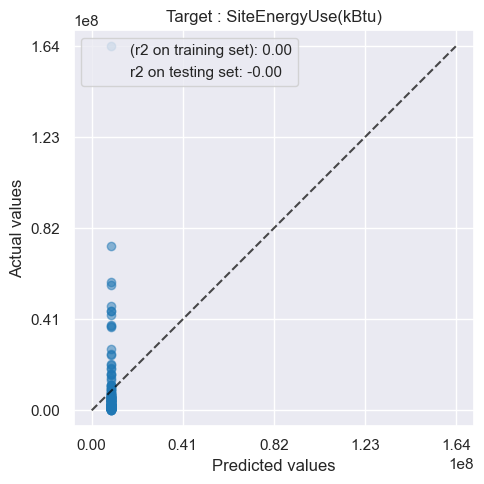

In [173]:
# Pas vraiment besoin du pipeline pour les dummy regressors,
# mais comme ça on a une première version

def pipe_simple_dummy(alea, y, strategy, scaler):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("dummy_regressor", DummyRegressor(strategy=strategy),)
        ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration
    if alea == 0:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)


def test_simple_dummy_n_times(y=y_E, strategy='mean', scaler=None):
    # Rappel modèle et cible
    print(f'Modèle : dummy simple ({strategy})')
    print('target :', y.name, '\n')

    for n in range(nb_iter):
        print('Iteration ', n+1)
        pipe_simple_dummy(alea=n, 
                          y=y, 
                          strategy=strategy, 
                          scaler=scaler)
   
   
test_simple_dummy_n_times()

# les resultats pour R2 sont en effet généralement très proches de 0.
# La RMSE est très élevée.


Modèle : dummy simple (mean)
target : SiteEUI(kBtu/sf) 

Iteration  1
R-squared (train) =  0.0
R-squared (test) =  -0.006825463686384259
RMSE (train) =  77.10750572962176
RMSE (test) =  55.03532538819267



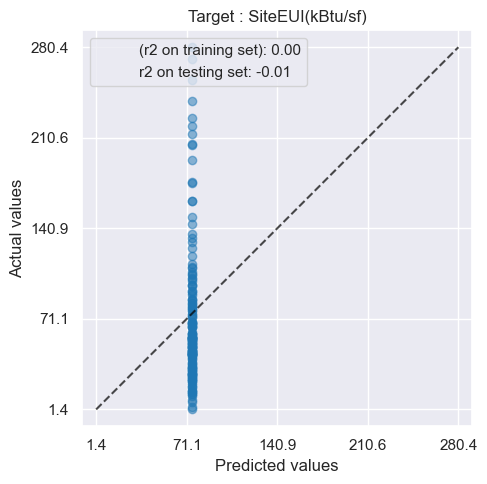

In [174]:
test_simple_dummy_n_times(y=y_EI)

# Résultats similaires


#### Avec crossvalidation 

Modèle : Dummy (mean)
target : SiteEnergyUse(kBtu) 

Iteration  1
Cross-Validation Scores:
Split 1 : r2 = -0.0018162079827754862
Split 2 : r2 = -0.005913574114065456
Split 3 : r2 = -0.0001825015443042144
Split 4 : r2 = -0.011139603047168212
Split 5 : r2 = -0.005163191076361873
R-squared (val) =  -0.0048430155529350484
R-squared (train) =  0.0
R-squared (test) =  -0.00012069287909355353
RMSE (val) =  32515473.00439895
RMSE (train) =  32473309.463109035
RMSE (test) =  17448575.864873912

{'model': 'Dummy (mean)', 'set': 'data1', 'scaler': None, 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': -0.00012069287909355353, 'r2_test_std': 0.0, 'rmse_test_moy': 17448575.864873912, 'rmse_test_std': 0.0, 'r2_train_moy': 0.0, 'r2_train_std': 0.0, 'rmse_train_moy': 32473309.463109035, 'rmse_train_std': 0.0, 'r2_val_moy': -0.0048430155529350484, 'r2_val_std': 0.0, 'rmse_val_moy': 32515473.00439895, 'rmse_val_std': 0.0, 'time_fit_moy': 0.003659508001874201, 'time_fit_std': 0.0, 'time_predict_moy': 0.00

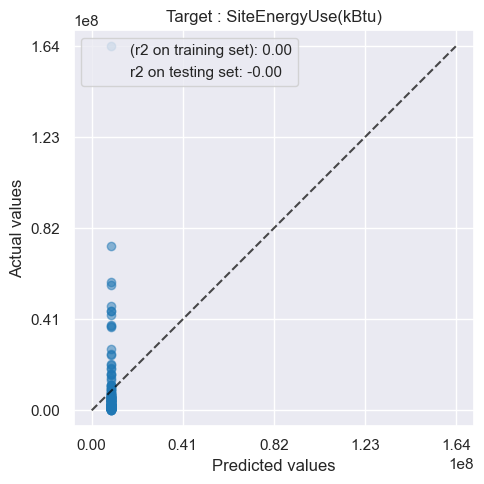

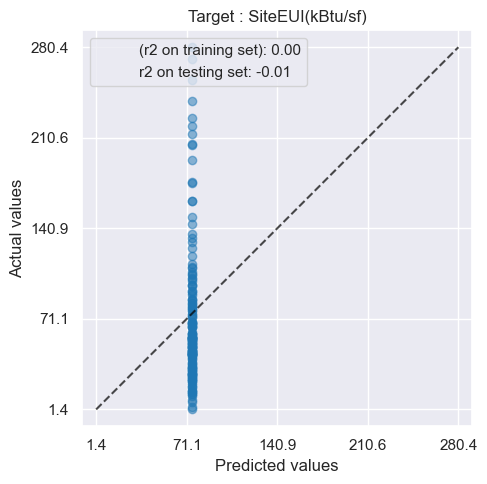

In [175]:
# Ces résultats sont excellents (^^) et on pourrait donc s'arrêter là, 
# mais... tous les modeles ne sont pas aussi stables que notre dummy !
# (à défaut d'être performant... il est stable !)

# Nous allons donc observer les performances de notre modèle 
# quand il est entrainé sur différent folds, en ajoutant une crossvalidation 
# cela peut permettre, dès l'entrainement, d'estimer la stabilité du modèle,
# sa capacité à généraliser, ou au contraire une tendance à overfitter...

# La mesure la plus significative demeure le score obtenu sur le testing set


def pipe_dummy(alea, y, strategy, scaler):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("dummy_regressor", DummyRegressor(strategy=strategy),)
        ])
    
    # Perform cross-validation (on training set) and display the scores for each split
    # Nous pourrions utiliser la fonction cross_val_score, mais 
    # cross_validate permet d'utilier plusieurs métriques.
    # Elle permet aussi d'enregistrer directement les temps de fitting et predicting 
    # sur les jeux de validation, mais nous allons plutôt comparer les temps sur les jeux de test.
    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")

    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration
    if alea == 0:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_dummy_n_times(y=y_E, strategy='mean', scaler=None):
    # Rappel modèle et cible
    print(f'Modèle : Dummy ({strategy})')
    print('target :', y.name, '\n')

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_dummy(alea=n, 
                                                                                      y=y, 
                                                                                      strategy=strategy, 
                                                                                      scaler=scaler)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Dummy (' + str(strategy) +')',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_dummy_n_times()
test_dummy_n_times(y=y_EI)

# Les valeurs de r2 sont légèrement supérieures sur le validation score,
# ce qui est attendu, et indique qu'il n'y a probablement pas de data leakage ou d'overfitting
# (à vérifier avec de "vrais" modèles, car dummy est de toutes façons incapable d'overfitter).

# De même, la rmse est plus importante sur le test score.


Modèle : Dummy (median)
target : SiteEnergyUse(kBtu) 

Iteration  1
Cross-Validation Scores:
Split 1 : r2 = -0.0609355311044697
Split 2 : r2 = -0.07134099331323052
Split 3 : r2 = -0.04825070758484351
Split 4 : r2 = -0.05549691851442207
Split 5 : r2 = -0.02822394346167867
R-squared (val) =  -0.052849618795728893
R-squared (train) =  -0.03656674489617595
R-squared (test) =  -0.11897013159717518
RMSE (val) =  33076389.4791701
RMSE (train) =  33061700.481668185
RMSE (test) =  18456231.398764506

{'model': 'Dummy (median)', 'set': 'data1', 'scaler': None, 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': -0.11897013159717518, 'r2_test_std': 0.0, 'rmse_test_moy': 18456231.398764506, 'rmse_test_std': 0.0, 'r2_train_moy': -0.03656674489617595, 'r2_train_std': 0.0, 'rmse_train_moy': 33061700.481668185, 'rmse_train_std': 0.0, 'r2_val_moy': -0.052849618795728893, 'r2_val_std': 0.0, 'rmse_val_moy': 33076389.4791701, 'rmse_val_std': 0.0, 'time_fit_moy': 0.0045485679984267335, 'time_fit_std': 0.0, 'ti

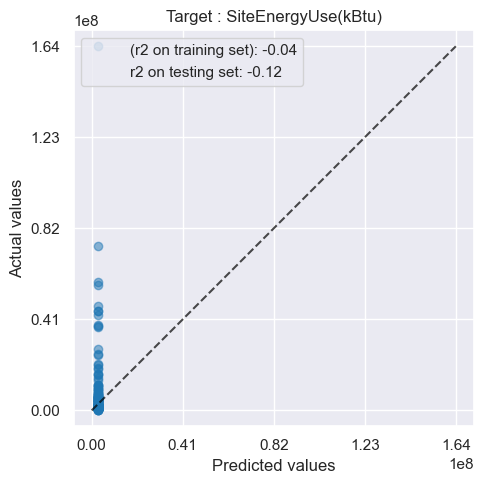

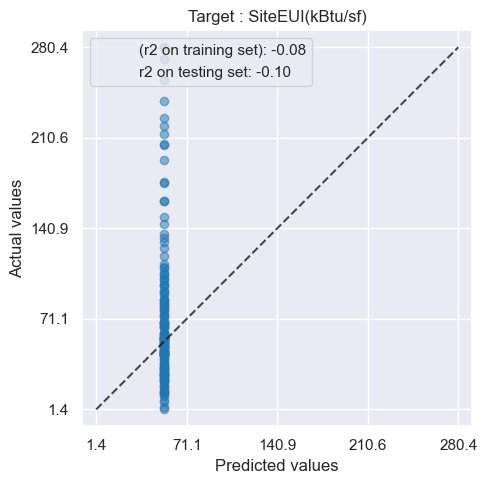

In [176]:
# idem si l'on prédit systématiquement la valeur médiane

test_dummy_n_times(y=y_E, strategy='median')
test_dummy_n_times(y=y_EI, strategy='median')

# Remarque : Prédire l'intensité de la consommation est-il plus difficile ?
# (scores  inférieurs ?) il semble que oui ici
# (à vérifier à la fin)


## 2 Développement et simulation d’un premier modèle

### 2.1 Sans gridsearch

Modèle : Ridge (not tuned)
target :  SiteEnergyUse(kBtu)
Iteration  1
Cross-Validation Scores:
Split 1 : r2 = 0.45892528797010823
Split 2 : r2 = 0.3644354149945226
Split 3 : r2 = 0.19283720716041486
Split 4 : r2 = 0.22475181531423394
Split 5 : r2 = 0.8672823192783902
R-squared (val) =  0.42164640894353395
R-squared (train) =  0.6717789021670891
R-squared (test) =  0.1346992366895975
RMSE (val) =  19549010.095160715
RMSE (train) =  18604148.531440865
RMSE (test) =  16229955.27094733

{'model': 'Ridge (not tuned)', 'set': 'data1', 'scaler': None, 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.1346992366895975, 'r2_test_std': 0.0, 'rmse_test_moy': 16229955.27094733, 'rmse_test_std': 0.0, 'r2_train_moy': 0.6717789021670891, 'r2_train_std': 0.0, 'rmse_train_moy': 18604148.531440865, 'rmse_train_std': 0.0, 'r2_val_moy': 0.42164640894353395, 'r2_val_std': 0.0, 'rmse_val_moy': 19549010.095160715, 'rmse_val_std': 0.0, 'time_fit_moy': 0.004397439002786996, 'time_fit_std': 0.0, 'time_predict_m

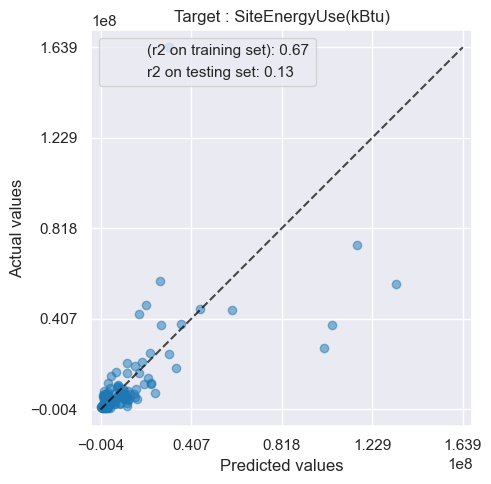

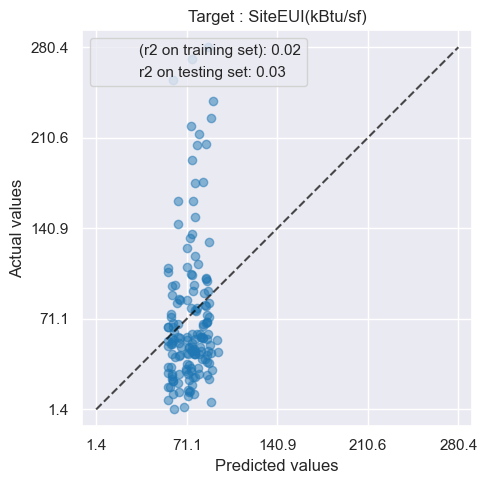

In [177]:
# Modèle choisi : régression ridge (modèle simple et stable)

# Ridge regression is a linear regression variant that introduces L2 regularization to prevent overfitting. 
# It can handle multicollinearity in the data.

# default alpha value here is alpha = 1.0


def pipe_ridge(alea, y, scaler):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge_regressor", Ridge())
    ])
         
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration
    if alea == 0:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_ridge_n_times(y=y_E, scaler=None):
    print(f'Modèle : Ridge (not tuned)')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_ridge(alea=n, 
                                                                                                        y=y, 
                                                                                                        scaler=scaler)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Ridge (not tuned)',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)

test_ridge_n_times()
test_ridge_n_times(y=y_EI)


Modèle : Ridge (not tuned)
target :  SiteEnergyUse(kBtu)
Iteration  1
Cross-Validation Scores:
Split 1 : r2 = 0.6979897172978864
Split 2 : r2 = 0.6728017378843858
Split 3 : r2 = 0.15923004271273655
Split 4 : r2 = 0.20202493926072784
Split 5 : r2 = 0.920711516607952
R-squared (val) =  0.5305515907527377
R-squared (train) =  0.7704013495073293
R-squared (test) =  0.4967585690951417
RMSE (val) =  17627516.614347104
RMSE (train) =  15560058.191219658
RMSE (test) =  12377187.606720941

{'model': 'Ridge (not tuned)', 'set': 'data1', 'scaler': StandardScaler(), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.4967585690951417, 'r2_test_std': 0.0, 'rmse_test_moy': 12377187.606720941, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7704013495073293, 'r2_train_std': 0.0, 'rmse_train_moy': 15560058.191219658, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5305515907527377, 'r2_val_std': 0.0, 'rmse_val_moy': 17627516.614347104, 'rmse_val_std': 0.0, 'time_fit_moy': 0.01082863600095152, 'time_fit_std': 0.0, 'time_

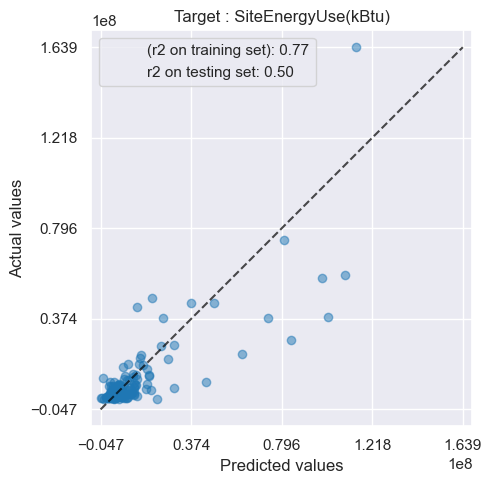

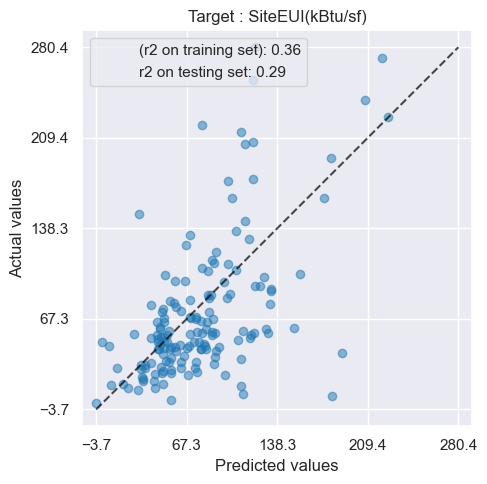

In [178]:
# Résultats encore très mauvais pour l'instant,
# Notamment (principalement?) parce que nos features numériques n'ont pas encore été transformées
# (scaling)

# Nous testerons bientôt différentes méthodes de scaling, par exemple :

test_ridge_n_times(scaler=StandardScaler())
test_ridge_n_times(y=y_EI, scaler=StandardScaler())

# C'est tout de suite mieux !
# Avant cela, il nous reste cependant à optimiser la valeur du paramètre alpha.
# ce qui rendra note modèle + performant 
# (et + stable, car on peut observer sur les splits que pour l'instant les r2 varient bcp)

# Ajoutons donc une étape de gridsearchcv


### 2.2 Avec GridSearchCV

Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1
Best alpha: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.6979897172978864
Split 2 : r2 = 0.6728017378843858
Split 3 : r2 = 0.15923004271273655
Split 4 : r2 = 0.20202493926072784
Split 5 : r2 = 0.920711516607952
R-squared (val) =  0.5305515907527377
R-squared (train) =  0.7704013495073293
R-squared (test) =  0.4967585690951417
RMSE (val) =  17627516.614347104
RMSE (train) =  15560058.191219658
RMSE (test) =  12377187.606720941

{'model': 'Ridge (tuned)', 'set': 'data1', 'scaler': StandardScaler(), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.4967585690951417, 'r2_test_std': 0.0, 'rmse_test_moy': 12377187.606720941, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7704013495073293, 'r2_train_std': 0.0, 'rmse_train_moy': 15560058.191219658, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5305515907527377, 'r2_val_std': 0.0, 'rmse_val_moy': 17627516.614347104, 'rmse_val_std': 0.0, 'time_fit_moy': 0.010287779001373565, 'time_fit_std': 0.0,

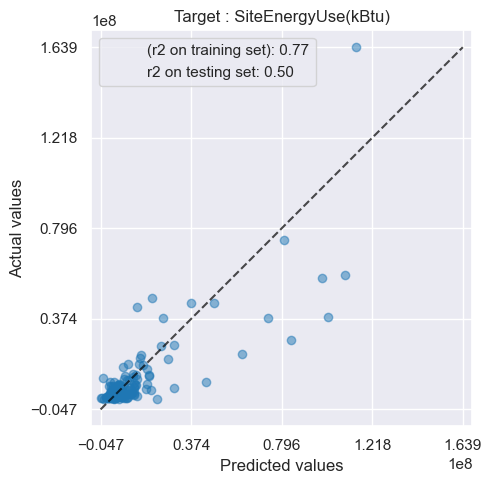

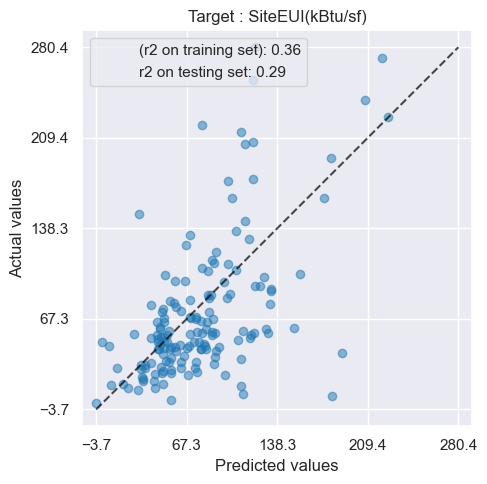

In [179]:
def pipe_ridge_tuned(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge_regressor", Ridge())
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'ridge_regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters 
    best_alpha = grid_search.best_params_['ridge_regressor__alpha']
    print(f"Best alpha: {best_alpha}")

    # Create a pipeline with the preprocessor and the tuned Ridge regressor
    pipeline_with_tuned_ridge = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ridge_regressor", Ridge(alpha=best_alpha))  # Use the tuned alpha value here
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_ridge, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_ridge, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_ridge, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_ridge.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_ridge_tuned_n_times(y=y_E, scaler=None, graph=False):
    print(f'Modèle : Ridge_tuned')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_ridge_tuned(alea=n, 
                                                                                                              y=y, 
                                                                                                              scaler=scaler,
                                                                                                              graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Ridge (tuned)',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }               
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_ridge_tuned_n_times(scaler=StandardScaler(), graph=True)
test_ridge_tuned_n_times(y=y_EI, scaler=StandardScaler(), graph=True)

# r2 augmente un peu


### Première comparaison entre modèles

In [180]:
affichage_results()


model    set            scaler               target  \
6  Ridge (not tuned)  data1  StandardScaler()  SiteEnergyUse(kBtu)   
8      Ridge (tuned)  data1  StandardScaler()  SiteEnergyUse(kBtu)   
7  Ridge (not tuned)  data1  StandardScaler()     SiteEUI(kBtu/sf)   
9      Ridge (tuned)  data1  StandardScaler()     SiteEUI(kBtu/sf)   
4  Ridge (not tuned)  data1              None  SiteEnergyUse(kBtu)   
5  Ridge (not tuned)  data1              None     SiteEUI(kBtu/sf)   
0       Dummy (mean)  data1              None  SiteEnergyUse(kBtu)   
1       Dummy (mean)  data1              None     SiteEUI(kBtu/sf)   
3     Dummy (median)  data1              None     SiteEUI(kBtu/sf)   
2     Dummy (median)  data1              None  SiteEnergyUse(kBtu)   

   r2_test_moy  r2_test_std  rmse_test_moy  rmse_test_std  r2_train_moy  \
6     0.496759          0.0   1.237719e+07            0.0      0.770401   
8     0.496759          0.0   1.237719e+07            0.0      0.770401   
7     0.290275          0.0   4.620720e+01            0.0      0.358390   
9     0.290275          0.0   4.620720e+01            0.0      0.358390   
4     0.134699          0.0   1.622996e+07            0.0      0.671779   
5     0.032619          0.0   5.394649e+01            0.0      0.016342   
0    -0.000121          0.0   1.744858e+07            0.0      0.000000   
1    -0.006825          0.0   5.503533e+01            0.0      0.000000   
3    -0.100714          0.0   5.754423e+01            0.0     -0.080946   
2    -0.118970          0.0   1.845623e+07            0.0     -0.036567   

   r2_train_std  rmse_train_moy  rmse_train_std  r2_val_moy  r2_val_std  \
6           0.0    1.556006e+07             0.0    0.530552         0.0   
8           0.0    1.556006e+07             0.0    0.530552         0.0   
7           0.0    6.176353e+01             0.0    0.289749         0.0   
9           0.0    6.176353e+01             0.0    0.289749         0.0   
4           0.0    1.860415e+07             0.0    0.421646         0.0   
5           0.0    7.647486e+01             0.0    0.014103         0.0   
0           0.0    3.247331e+07             0.0   -0.004843         0.0   
1           0.0    7.710751e+01             0.0   -0.001964         0.0   
3           0.0    8.016755e+01             0.0   -0.081170         0.0   
2           0.0    3.306170e+07             0.0   -0.052850         0.0   

   rmse_val_moy  rmse_val_std  time_fit_moy  time_fit_std  time_predict_moy  \
6  1.762752e+07           0.0      0.010829           0.0          0.002660   
8  1.762752e+07           0.0      0.010288           0.0          0.002406   
7  6.548434e+01           0.0      0.010317           0.0          0.002803   
9  6.548434e+01           0.0      0.009190           0.0          0.002088   
4  1.954901e+07           0.0      0.004397           0.0          0.002148   
5  7.655368e+01           0.0      0.004772           0.0          0.002048   
0  3.251547e+07           0.0      0.003660           0.0          0.002266   
1  7.713661e+01           0.0      0.003492           0.0          0.001937   
3  8.016828e+01           0.0      0.003922           0.0          0.003257   
2  3.307639e+07           0.0      0.004549           0.0          0.002313   

   time_predict_std  
6               0.0  
8               0.0  
7               0.0  
9               0.0  
4               0.0  
5               0.0  
0               0.0  
1               0.0  
3               0.0  
2               0.0

In [181]:
# Remarque : résultats intéressants

# Ridge not tuned outperforms ridge tuned predicting y_EI ! 
# Our alpha is not the best yet

# Or ridge tuned is more unstable ?


## 3 Amélioration du feature engineering

### 3.1 different scalers (preprocessing)

In [182]:
model_results = []

scalers = [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler(quantile_range=(25, 75)),
           PowerTransformer(method="yeo-johnson"), Normalizer(),
           QuantileTransformer(output_distribution="uniform", random_state=42), 
           QuantileTransformer(output_distribution="normal", random_state=42)
           ]

# for scaler in scalers:
    # test_ridge_tuned_n_times(scaler=scaler)
    # test_ridge_tuned_n_times(y=y_EI, scaler=scaler)

# affichage_results()


In [183]:
# Alors...
# Comment choisir ?

# Pour la target y_EI (notre cible principale) :
# les meilleures methodes sont RobustScaler() et StandardScaler(), 
# avec des résultats quasi-identiques (r2_test = 0.52).

# MaxAbsScaler() et MinMaxScaler() suivent de près, à 0.49

# 4 méthodes ont ici un effet négatif (r2 inférieur au r2 obtenu sans scaling) :
# les 2 QuantileTransformers, Normalizer() et PowerTransformers() semblent donc à éviter
# (pour ce modèle en tous cas, et pour l'état actuel de notre feature engineering)

# Remarque : la "vitoire" du RobustScaler indique probablement la présence d'outliers pour cette target.
# Ces quatre méthodes ont aussi des performances proches du maximum pour la deuxième target.

# QuantileTransformer(), PowerTransformer() et Normalizer() semblent instables,
# leurs résultats diffèrent remarquablement selon les targets.

# Pour la seconde target, la plupart des résultats sont quasi-identiques (entre 0.29 et 0.31)
# Nous allons donc utiliser RobustScaler() pour la suite.

robust = RobustScaler(quantile_range=(25, 75))


### 3.2 passage au log de y et autres transformations sur notre target

57133.19922
Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1
Best alpha: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.6964365269351969
Split 2 : r2 = 0.6737684218401101
Split 3 : r2 = 0.15957788532725448
Split 4 : r2 = 0.20384281629283152
Split 5 : r2 = 0.920999272301477
R-squared (val) =  0.530924984539374
R-squared (train) =  0.7703845103594038
R-squared (test) =  0.49917318835964897
RMSE (val) =  17618924.706370443
RMSE (train) =  15560628.781066362
RMSE (test) =  12347458.206927193

{'model': 'Ridge (tuned)', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.49917318835964897, 'r2_test_std': 0.0, 'rmse_test_moy': 12347458.206927193, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7703845103594038, 'r2_train_std': 0.0, 'rmse_train_moy': 15560628.781066362, 'rmse_train_std': 0.0, 'r2_val_moy': 0.530924984539374, 'r2_val_std': 0.0, 'rmse_val_moy': 17618924.706370443, 'rmse_val_std': 0.0, 'time_fit_moy': 0.0094866

Best alpha: 0.01
Cross-Validation Scores:
Split 1 : r2 = 0.564729934264488
Split 2 : r2 = 0.5626009966328989
Split 3 : r2 = 0.5215596521349657
Split 4 : r2 = 0.5096840099841107
Split 5 : r2 = -1.2426478075749983
R-squared (val) =  0.183185357088293
R-squared (train) =  0.5980707154705958
R-squared (test) =  0.5308859346933777
RMSE (val) =  1.209755780847945
RMSE (train) =  0.8307969084494302
RMSE (test) =  0.9041249604444151

{'model': 'Ridge (tuned)', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'log(y_E)', 'r2_test_moy': 0.5308859346933777, 'r2_test_std': 0.0, 'rmse_test_moy': 0.9041249604444151, 'rmse_test_std': 0.0, 'r2_train_moy': 0.5980707154705958, 'r2_train_std': 0.0, 'rmse_train_moy': 0.8307969084494302, 'rmse_train_std': 0.0, 'r2_val_moy': 0.183185357088293, 'r2_val_std': 0.0, 'rmse_val_moy': 1.209755780847945, 'rmse_val_std': 0.0, 'time_fit_moy': 0.0083223799992993, 'time_fit_std': 0.0, 'time_predict_moy': 0.004826813001272967, 'time_predict_std

model    set                                 scaler  \
3  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
1  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
0  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
2  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   

                target  r2_test_moy  r2_test_std  rmse_test_moy  \
3            sqrt(y_E)     0.682372          0.0   1.017632e+03   
1             log(y_E)     0.530886          0.0   9.041250e-01   
0  SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
2          y_E squared   -21.837146          0.0   1.069769e+16   

   rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
3            0.0      0.716453           0.0    1.053459e+03             0.0   
1            0.0      0.598071           0.0    8.307969e-01             0.0   
0            0.0      0.770385           0.0    1.556063e+07             0.0   
2            0.0      0.873868           0.0    7.660502e+15             0.0   

   r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
3    0.491387         0.0  1.499642e+03           0.0      0.008744   
1    0.183185         0.0  1.209756e+00           0.0      0.008322   
0    0.530925         0.0  1.761892e+07           0.0      0.009487   
2   -0.326618         0.0  1.892489e+16           0.0      0.007897   

   time_fit_std  time_predict_moy  time_predict_std  
3           0.0          0.002621               0.0  
1           0.0          0.004827               0.0  
0           0.0          0.003276               0.0  
2           0.0          0.002256               0.0

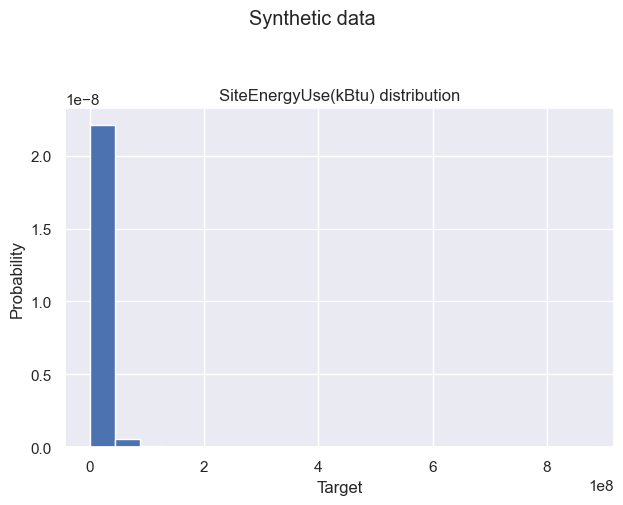

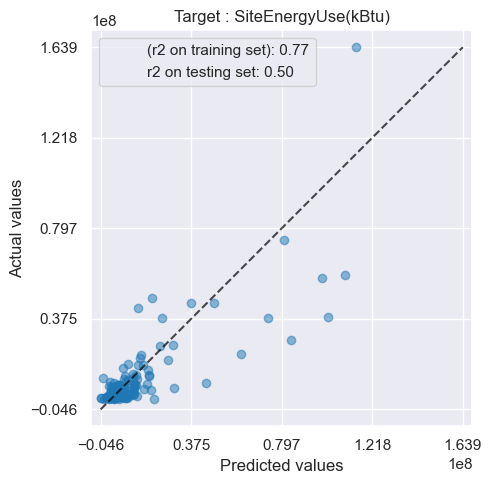

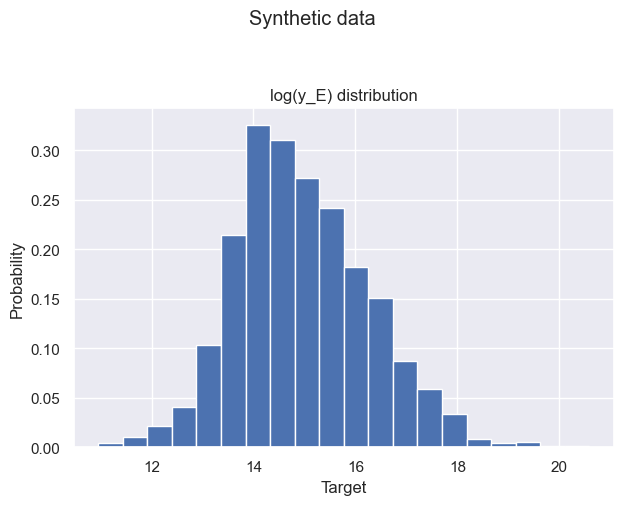

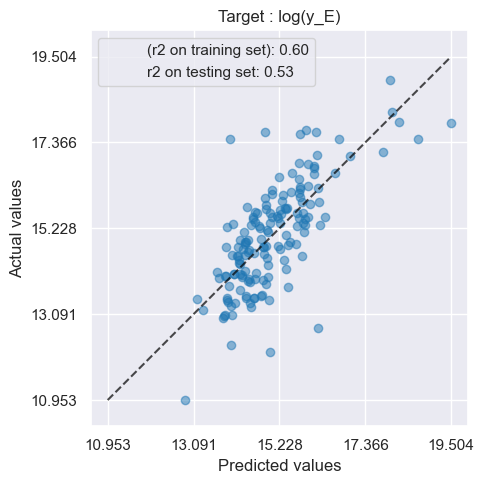

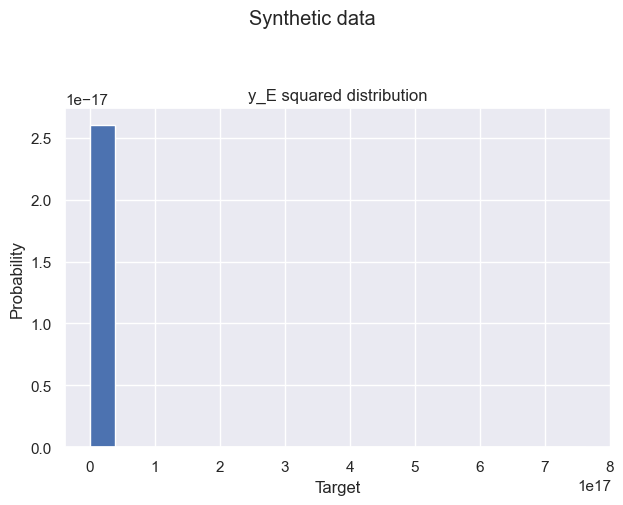

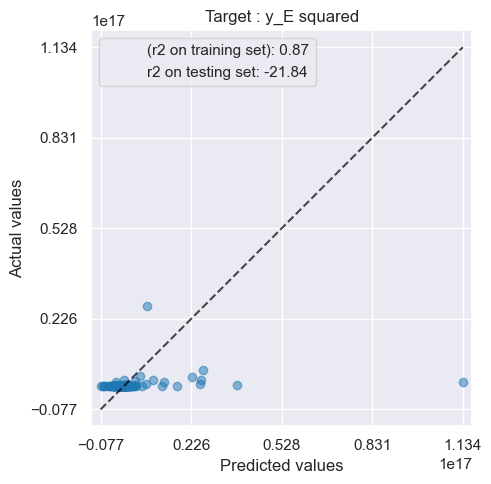

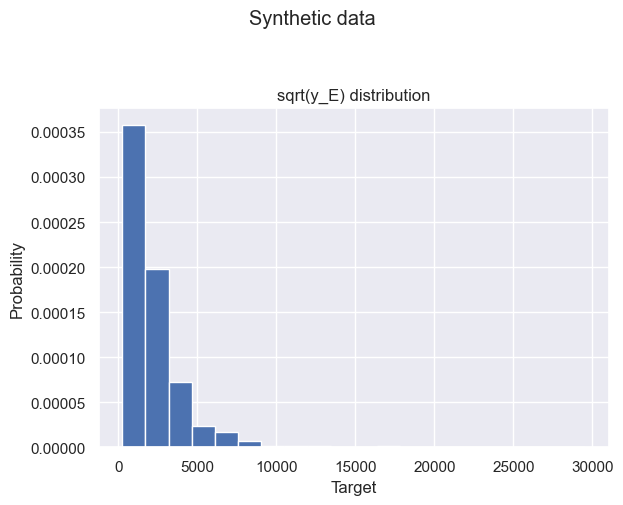

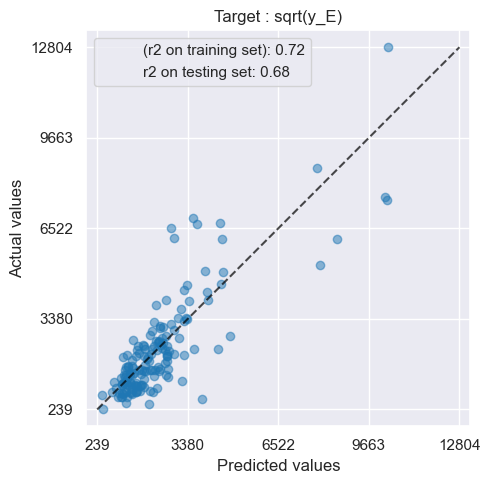

In [184]:
model_results = []

print(y_E.min())
# OK, pas de valeur <= 0

y_E_log = pd.Series(np.log(y_E))
y_E_log.name = 'log(y_E)'

y_E_squared = pd.Series(y_E * y_E)
y_E_squared.name = 'y_E squared'

y_E_root = pd.Series(np.sqrt(y_E))
y_E_root.name = 'sqrt(y_E)'

transformed_target_list = [y_E, y_E_log, y_E_squared, y_E_root]

for t in transformed_target_list:
    f, ax = plt.subplots(1, 1)

    ax.hist(t, bins=20, density=True)
    # ax.set_xlim([0, t.max()])
    ax.set_ylabel("Probability")
    ax.set_xlabel("Target")
    ax.set_title(f"{t.name} distribution")

    f.suptitle("Synthetic data", y=1.05)
    plt.tight_layout()
    plt.show

    test_ridge_tuned_n_times(y=t, scaler=robust, graph=True)

affichage_results()

# Aucune de ces transformations sur notre target n'est utile à notre modèle,
# Retournouns donc au feature engineering sur les variables d'entrainement.


In [185]:
# a supp + tard ?

model_results = []

test_ridge_tuned_n_times(scaler=robust)
test_ridge_tuned_n_times(y=y_EI, scaler=robust)


Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1
Best alpha: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.6964365269351969
Split 2 : r2 = 0.6737684218401101
Split 3 : r2 = 0.15957788532725448
Split 4 : r2 = 0.20384281629283152
Split 5 : r2 = 0.920999272301477
R-squared (val) =  0.530924984539374
R-squared (train) =  0.7703845103594038
R-squared (test) =  0.49917318835964897
RMSE (val) =  17618924.706370443
RMSE (train) =  15560628.781066362
RMSE (test) =  12347458.206927193

{'model': 'Ridge (tuned)', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.49917318835964897, 'r2_test_std': 0.0, 'rmse_test_moy': 12347458.206927193, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7703845103594038, 'r2_train_std': 0.0, 'rmse_train_moy': 15560628.781066362, 'rmse_train_std': 0.0, 'r2_val_moy': 0.530924984539374, 'r2_val_std': 0.0, 'rmse_val_moy': 17618924.706370443, 'rmse_val_std': 0.0, 'time_fit_moy': 0.00895295900045312, 

### 3.1 Remplacement de neighborhood par les coordonnées

In [186]:
# (Voir fin du notebook 1)

df = pd.read_csv('clean_data2_coordinates.csv', sep=',')

print(df.shape)
display(df.head())

cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data2')

test_ridge_tuned_n_times(y=y_E, scaler=robust)
test_ridge_tuned_n_times(y=y_EI, scaler=robust)

affichage_results()

# Non plus


(1548, 16)


BuildingType PrimaryPropertyType  Latitude  Longitude  YearBuilt  \
0  NonResidential               Hotel  47.61220 -122.33799       1927   
1  NonResidential               Hotel  47.61317 -122.33393       1996   
2  NonResidential               Hotel  47.61393 -122.33810       1969   
3  NonResidential               Hotel  47.61412 -122.33664       1926   
4  NonResidential               Hotel  47.61375 -122.34047       1980   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  proportion_parking  \
0                1.0              12             88434            0.000000   
1                1.0              11            103566            0.145453   
2                1.0              41            956110            0.205748   
3                1.0              10             61320            0.000000   
4                1.0              18            175580            0.353115   

   proportion_electricity  proportion_gaz  proportion_steam  \
0                0.546060        0.176638          0.277302   
1                0.386609        0.613391          0.000000   
2                0.682307        0.020579          0.297113   
3                0.407519        0.266567          0.325913   
4                0.378802        0.621198          0.000000   

   SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0            7226362.5         81.699997             249.98   
1            8387933.0         94.800003             295.86   
2           72587024.0         96.000000            2089.28   
3            6794584.0        110.800003             286.43   
4           14172606.0        114.800003             505.01   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
2                   2.19  
3                   4.67  
4                   2.88

Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1
Best alpha: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.6974485912422834
Split 2 : r2 = 0.6762521669360305
Split 3 : r2 = 0.1619075038237141
Split 4 : r2 = 0.20346980330059827
Split 5 : r2 = 0.9245069580653081
R-squared (val) =  0.5327170046735868
R-squared (train) =  0.7693221140902355
R-squared (test) =  0.5006448850834383
RMSE (val) =  17536941.923457634
RMSE (train) =  15596585.579640556
RMSE (test) =  12329303.145568207

{'model': 'Ridge (tuned)', 'set': 'data2', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.5006448850834383, 'r2_test_std': 0.0, 'rmse_test_moy': 12329303.145568207, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7693221140902355, 'r2_train_std': 0.0, 'rmse_train_moy': 15596585.579640556, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5327170046735868, 'r2_val_std': 0.0, 'rmse_val_moy': 17536941.923457634, 'rmse_val_std': 0.0, 'time_fit_moy': 0.006334668996714754,

model    set                                 scaler  \
2  Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
3  Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
1  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   

                target  r2_test_moy  r2_test_std  rmse_test_moy  \
2  SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0  SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
3     SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
1     SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   

   rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
2            0.0      0.769322           0.0    1.559659e+07             0.0   
0            0.0      0.770385           0.0    1.556063e+07             0.0   
3            0.0      0.345371           0.0    6.238705e+01             0.0   
1            0.0      0.358301           0.0    6.176782e+01             0.0   

   r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
2    0.532717         0.0  1.753694e+07           0.0      0.006335   
0    0.530925         0.0  1.761892e+07           0.0      0.008953   
3    0.307029         0.0  6.472743e+01           0.0      0.006295   
1    0.293015         0.0  6.531840e+01           0.0      0.009681   

   time_fit_std  time_predict_moy  time_predict_std  
2           0.0          0.002119               0.0  
0           0.0          0.003148               0.0  
3           0.0          0.001904               0.0  
1           0.0          0.002249               0.0

#### En gardant à la fois neighborhood et les coordonnées

In [187]:
df = pd.read_csv('clean_data3_both.csv', sep=',')

print(df.shape)
display(df.head())

cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data3')

test_ridge_tuned_n_times(y=y_E, scaler=robust)
test_ridge_tuned_n_times(y=y_EI, scaler=robust)

affichage_results()


(1548, 17)


BuildingType PrimaryPropertyType Neighborhood  YearBuilt  \
0  NonResidential               Hotel     DOWNTOWN       1927   
1  NonResidential               Hotel     DOWNTOWN       1996   
2  NonResidential               Hotel     DOWNTOWN       1969   
3  NonResidential               Hotel     DOWNTOWN       1926   
4  NonResidential               Hotel     DOWNTOWN       1980   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  proportion_parking  \
0                1.0              12             88434            0.000000   
1                1.0              11            103566            0.145453   
2                1.0              41            956110            0.205748   
3                1.0              10             61320            0.000000   
4                1.0              18            175580            0.353115   

   proportion_electricity  proportion_gaz  proportion_steam  \
0                0.546060        0.176638          0.277302   
1                0.386609        0.613391          0.000000   
2                0.682307        0.020579          0.297113   
3                0.407519        0.266567          0.325913   
4                0.378802        0.621198          0.000000   

   SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0            7226362.5         81.699997             249.98   
1            8387933.0         94.800003             295.86   
2           72587024.0         96.000000            2089.28   
3            6794584.0        110.800003             286.43   
4           14172606.0        114.800003             505.01   

   GHGEmissionsIntensity  Latitude  Longitude  
0                   2.83  47.61220 -122.33799  
1                   2.86  47.61317 -122.33393  
2                   2.19  47.61393 -122.33810  
3                   4.67  47.61412 -122.33664  
4                   2.88  47.61375 -122.34047

Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1
Best alpha: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.6984827087641019
Split 2 : r2 = 0.6739179654776382
Split 3 : r2 = 0.16047726016695663
Split 4 : r2 = 0.2005958511274123
Split 5 : r2 = 0.9219309104955861
R-squared (val) =  0.531080939206339
R-squared (train) =  0.7709881754689226
R-squared (test) =  0.5036460996077488
RMSE (val) =  17598739.957397223
RMSE (train) =  15540160.67000794
RMSE (test) =  12292196.636811059

{'model': 'Ridge (tuned)', 'set': 'data3', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.5036460996077488, 'r2_test_std': 0.0, 'rmse_test_moy': 12292196.636811059, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7709881754689226, 'r2_train_std': 0.0, 'rmse_train_moy': 15540160.67000794, 'rmse_train_std': 0.0, 'r2_val_moy': 0.531080939206339, 'r2_val_std': 0.0, 'rmse_val_moy': 17598739.957397223, 'rmse_val_std': 0.0, 'time_fit_moy': 0.008488108000165084, 'ti

model    set                                 scaler  \
4  Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
2  Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
3  Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
5  Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
1  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   

                target  r2_test_moy  r2_test_std  rmse_test_moy  \
4  SiteEnergyUse(kBtu)     0.503646          0.0   1.229220e+07   
2  SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0  SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
3     SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
5     SiteEUI(kBtu/sf)     0.311591          0.0   4.550798e+01   
1     SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   

   rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
4            0.0      0.770988           0.0    1.554016e+07             0.0   
2            0.0      0.769322           0.0    1.559659e+07             0.0   
0            0.0      0.770385           0.0    1.556063e+07             0.0   
3            0.0      0.345371           0.0    6.238705e+01             0.0   
5            0.0      0.358582           0.0    6.175431e+01             0.0   
1            0.0      0.358301           0.0    6.176782e+01             0.0   

   r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
4    0.531081         0.0  1.759874e+07           0.0      0.008488   
2    0.532717         0.0  1.753694e+07           0.0      0.006335   
0    0.530925         0.0  1.761892e+07           0.0      0.008953   
3    0.307029         0.0  6.472743e+01           0.0      0.006295   
5    0.292651         0.0  6.533571e+01           0.0      0.010246   
1    0.293015         0.0  6.531840e+01           0.0      0.009681   

   time_fit_std  time_predict_moy  time_predict_std  
4           0.0          0.003361               0.0  
2           0.0          0.002119               0.0  
0           0.0          0.003148               0.0  
3           0.0          0.001904               0.0  
5           0.0          0.002626               0.0  
1           0.0          0.002249               0.0

In [188]:
# Etonnant, non ?

# data1 (seulement 'neighborhood') a des performances systématiquement meilleures que celles de 
# data3 (neighborhood + coordonnées)

# pour data2 (seulement les coordonnées), les perfs sont instables.

# Interprétation : Neighborhood est bien une feature utile à notre modèle
# pour prédire la conso énergétique totale. En revanche, ajouter les coordonnées en absolu,
# qui pourraient aider s'il y avait un impact de la situation géographique à l'échelle de la ville, 
# impacte ici négativement la qualité des précisions du modèle. 
# En quelque sorte, ce n'est pas la bonne échelle pour décrire/prédire efficacement.

# Problème : cette explication n'est pas vérifiée pour notre deuxième cible y_EI.
# Pour cette cible, voir plus loin (fin de cette partie)
# pour une idée de feature engineering spécifique.

# Garder toute la data semble donc avoir un effet négatif pour prédire notre target principale,
# conservons 'neighborhood' comme seule feature géographique.

df = pd.read_csv('clean_data1.csv', sep=',')
cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data1')


### 3.3 Utilisation des features « ...PropertyUseType »

In [189]:
# Nos premières tentatives d'amélioration du feature engineering sont... 
# plutôt inutiles pour l'instant ! (Excepté le choix du scaler)

# Abandonnons donc neighborhood, et conservons les coordonnées.

df = pd.read_csv('clean_data4_usetypes.csv', sep=',')

print(df.shape)
display(df.head())

cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data4')


# test_dummy_n_times(y=y_E, strategy='mean')
# test_dummy_n_times(y=y_EI, strategy='mean')

# test_ridge_n_times(y=y_E)
# test_ridge_n_times(y=y_EI)

test_ridge_tuned_n_times(y=y_E, scaler=robust)
test_ridge_tuned_n_times(y=y_EI, scaler=robust)


affichage_results()

# nope
# tjs pas


(1548, 28)


BuildingType PrimaryPropertyType Neighborhood  YearBuilt  \
0  NonResidential               Hotel     DOWNTOWN       1927   
1  NonResidential               Hotel     DOWNTOWN       1996   
2  NonResidential               Hotel     DOWNTOWN       1969   
3  NonResidential               Hotel     DOWNTOWN       1926   
4  NonResidential               Hotel     DOWNTOWN       1980   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  proportion_parking  \
0                1.0              12             88434            0.000000   
1                1.0              11            103566            0.145453   
2                1.0              41            956110            0.205748   
3                1.0              10             61320            0.000000   
4                1.0              18            175580            0.353115   

   proportion_electricity  proportion_gaz  proportion_steam  \
0                0.546060        0.176638          0.277302   
1                0.386609        0.613391          0.000000   
2                0.682307        0.020579          0.297113   
3                0.407519        0.266567          0.325913   
4                0.378802        0.621198          0.000000   

   SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0            7226362.5         81.699997             249.98   
1            8387933.0         94.800003             295.86   
2           72587024.0         96.000000            2089.28   
3            6794584.0        110.800003             286.43   
4           14172606.0        114.800003             505.01   

   GHGEmissionsIntensity  Other  Distribution Center   Parking     Hotel  \
0                   2.83    0.0                  0.0  0.000000  1.000000   
1                   2.86    0.0                  0.0  0.145453  0.809918   
2                   2.19    0.0                  0.0  0.000000  0.791220   
3                   4.67    0.0                  0.0  0.000000  1.000000   
4                   2.88    0.0                  0.0  0.387339  0.703070   

   Restaurant  Supermarket/Grocery Store  Medical Office  \
0    0.000000                        0.0             0.0   
1    0.044629                        0.0             0.0   
2    0.000000                        0.0             0.0   
3    0.000000                        0.0             0.0   
4    0.000000                        0.0             0.0   

   Non-Refrigerated Warehouse  K-12 School  Retail Store  Worship Facility  \
0                         0.0          0.0           0.0               0.0   
1                         0.0          0.0           0.0               0.0   
2                         0.0          0.0           0.0               0.0   
3                         0.0          0.0           0.0               0.0   
4                         0.0          0.0           0.0               0.0   

   Office  grouped_usetypes  
0     0.0               0.0  
1     0.0               0.0  
2     0.0               0.0  
3     0.0               0.0  
4     0.0               0.0

Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1


Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.6383285594730365
Split 2 : r2 = 0.5034917439969991
Split 3 : r2 = 0.19504370428061657
Split 4 : r2 = 0.23862938104057851
Split 5 : r2 = 0.9565083501326199
R-squared (val) =  0.50640034778477
R-squared (train) =  0.773800407815038
R-squared (test) =  0.58191512808265
RMSE (val) =  17234650.119274132
RMSE (train) =  15444450.463843396
RMSE (test) =  11281478.138026394

{'model': 'Ridge (tuned)', 'set': 'data4', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.58191512808265, 'r2_test_std': 0.0, 'rmse_test_moy': 11281478.138026394, 'rmse_test_std': 0.0, 'r2_train_moy': 0.773800407815038, 'r2_train_std': 0.0, 'rmse_train_moy': 15444450.463843396, 'rmse_train_std': 0.0, 'r2_val_moy': 0.50640034778477, 'r2_val_std': 0.0, 'rmse_val_moy': 17234650.119274132, 'rmse_val_std': 0.0, 'time_fit_moy': 0.0078022609995969106, 'time_fit_std': 0.0, 'time_predict_moy': 0.0020327199999883305, 'time_

model    set                                 scaler  \
6  Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
4  Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
2  Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
7  Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
3  Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
5  Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
1  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   

                target  r2_test_moy  r2_test_std  rmse_test_moy  \
6  SiteEnergyUse(kBtu)     0.581915          0.0   1.128148e+07   
4  SiteEnergyUse(kBtu)     0.503646          0.0   1.229220e+07   
2  SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0  SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
7     SiteEUI(kBtu/sf)     0.346450          0.0   4.434084e+01   
3     SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
5     SiteEUI(kBtu/sf)     0.311591          0.0   4.550798e+01   
1     SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   

   rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
6            0.0      0.773800           0.0    1.544445e+07             0.0   
4            0.0      0.770988           0.0    1.554016e+07             0.0   
2            0.0      0.769322           0.0    1.559659e+07             0.0   
0            0.0      0.770385           0.0    1.556063e+07             0.0   
7            0.0      0.351299           0.0    6.210393e+01             0.0   
3            0.0      0.345371           0.0    6.238705e+01             0.0   
5            0.0      0.358582           0.0    6.175431e+01             0.0   
1            0.0      0.358301           0.0    6.176782e+01             0.0   

   r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
6    0.506400         0.0  1.723465e+07           0.0      0.007802   
4    0.531081         0.0  1.759874e+07           0.0      0.008488   
2    0.532717         0.0  1.753694e+07           0.0      0.006335   
0    0.530925         0.0  1.761892e+07           0.0      0.008953   
7    0.301147         0.0  6.483752e+01           0.0      0.007926   
3    0.307029         0.0  6.472743e+01           0.0      0.006295   
5    0.292651         0.0  6.533571e+01           0.0      0.010246   
1    0.293015         0.0  6.531840e+01           0.0      0.009681   

   time_fit_std  time_predict_moy  time_predict_std  
6           0.0          0.002033               0.0  
4           0.0          0.003361               0.0  
2           0.0          0.002119               0.0  
0           0.0          0.003148               0.0  
7           0.0          0.002868               0.0  
3           0.0          0.001904               0.0  
5           0.0          0.002626               0.0  
1           0.0          0.002249               0.0

### 3.3 Passage au log(1 + x) quand skewness > 1 

In [190]:
# D'après le 'podium' ci-dessus, ce dernier feature engineering a diminué la performance du modèle

df = pd.read_csv('clean_data5_skew1.csv', sep=',')

print(df.shape)
display(df.head())

cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data5')

test_ridge_tuned_n_times(y=y_E, scaler=robust)
test_ridge_tuned_n_times(y=y_EI, scaler=robust)


affichage_results()

# de pire en pire


(1548, 15)


BuildingType PrimaryPropertyType Neighborhood  YearBuilt  \
0  NonResidential               Hotel     DOWNTOWN       1927   
1  NonResidential               Hotel     DOWNTOWN       1996   
2  NonResidential               Hotel     DOWNTOWN       1969   
3  NonResidential               Hotel     DOWNTOWN       1926   
4  NonResidential               Hotel     DOWNTOWN       1980   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  proportion_parking  \
0           1.098612        2.639057         11.390034            0.693147   
1           1.098612        2.564949         11.547984            0.763351   
2           1.098612        3.761200         13.770630            0.791067   
3           1.098612        2.484907         11.023894            0.693147   
4           1.098612        2.995732         12.075861            0.855740   

   proportion_electricity  proportion_gaz  proportion_steam  \
0                0.546060        0.176638          0.822991   
1                0.386609        0.613391          0.693147   
2                0.682307        0.020579          0.831653   
3                0.407519        0.266567          0.844113   
4                0.378802        0.621198          0.693147   

   SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0            7226362.5         81.699997             249.98   
1            8387933.0         94.800003             295.86   
2           72587024.0         96.000000            2089.28   
3            6794584.0        110.800003             286.43   
4           14172606.0        114.800003             505.01   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
2                   2.19  
3                   4.67  
4                   2.88

Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1


Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.4032826391071058
Split 2 : r2 = 0.3811688848009389
Split 3 : r2 = 0.025342261540234445
Split 4 : r2 = -0.11200443890397427
Split 5 : r2 = 0.28563632577335085
R-squared (val) =  0.19668513446353114
R-squared (train) =  0.4595654520779817
R-squared (test) =  -0.4785698559171643
RMSE (val) =  28449573.859910816
RMSE (train) =  23872511.06407675
RMSE (test) =  21215569.94968498

{'model': 'Ridge (tuned)', 'set': 'data5', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': -0.4785698559171643, 'r2_test_std': 0.0, 'rmse_test_moy': 21215569.94968498, 'rmse_test_std': 0.0, 'r2_train_moy': 0.4595654520779817, 'r2_train_std': 0.0, 'rmse_train_moy': 23872511.06407675, 'rmse_train_std': 0.0, 'r2_val_moy': 0.19668513446353114, 'r2_val_std': 0.0, 'rmse_val_moy': 28449573.859910816, 'rmse_val_std': 0.0, 'time_fit_moy': 0.008397995999985142, 'time_fit_std': 0.0, 'time_predict_moy': 0.002242154001578

model    set                                 scaler  \
6  Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
4  Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
2  Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
7  Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
3  Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
9  Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
5  Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
1  Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
8  Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   

                target  r2_test_moy  r2_test_std  rmse_test_moy  \
6  SiteEnergyUse(kBtu)     0.581915          0.0   1.128148e+07   
4  SiteEnergyUse(kBtu)     0.503646          0.0   1.229220e+07   
2  SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0  SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
7     SiteEUI(kBtu/sf)     0.346450          0.0   4.434084e+01   
3     SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
9     SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
5     SiteEUI(kBtu/sf)     0.311591          0.0   4.550798e+01   
1     SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   
8  SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   

   rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
6            0.0      0.773800           0.0    1.544445e+07             0.0   
4            0.0      0.770988           0.0    1.554016e+07             0.0   
2            0.0      0.769322           0.0    1.559659e+07             0.0   
0            0.0      0.770385           0.0    1.556063e+07             0.0   
7            0.0      0.351299           0.0    6.210393e+01             0.0   
3            0.0      0.345371           0.0    6.238705e+01             0.0   
9            0.0      0.357973           0.0    6.178361e+01             0.0   
5            0.0      0.358582           0.0    6.175431e+01             0.0   
1            0.0      0.358301           0.0    6.176782e+01             0.0   
8            0.0      0.459565           0.0    2.387251e+07             0.0   

   r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
6    0.506400         0.0  1.723465e+07           0.0      0.007802   
4    0.531081         0.0  1.759874e+07           0.0      0.008488   
2    0.532717         0.0  1.753694e+07           0.0      0.006335   
0    0.530925         0.0  1.761892e+07           0.0      0.008953   
7    0.301147         0.0  6.483752e+01           0.0      0.007926   
3    0.307029         0.0  6.472743e+01           0.0      0.006295   
9    0.292991         0.0  6.527751e+01           0.0      0.010288   
5    0.292651         0.0  6.533571e+01           0.0      0.010246   
1    0.293015         0.0  6.531840e+01           0.0      0.009681   
8    0.196685         0.0  2.844957e+07           0.0      0.008398   

   time_fit_std  time_predict_moy  time_predict_std  
6           0.0          0.002033               0.0  
4           0.0          0.003361               0.0  
2           0.0          0.002119               0.0  
0           0.0          0.003148               0.0  
7           0.0          0.002868               0.0  
3           0.0          0.001904               0.0  
9           0.0          0.002391               0.0  
5           0.0          0.002626               0.0  
1           0.0          0.002249               0.0  
8           0.0          0.002242               0.0

In [191]:
# ...

df = pd.read_csv('clean_data6_skew2.csv', sep=',')

print(df.shape)
display(df.head())

cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data6')

test_ridge_tuned_n_times(scaler=robust)
test_ridge_tuned_n_times(y=y_EI, scaler=robust)


affichage_results()


(1548, 15)


BuildingType PrimaryPropertyType Neighborhood  YearBuilt  \
0  NonResidential               Hotel     DOWNTOWN       1927   
1  NonResidential               Hotel     DOWNTOWN       1996   
2  NonResidential               Hotel     DOWNTOWN       1969   
3  NonResidential               Hotel     DOWNTOWN       1926   
4  NonResidential               Hotel     DOWNTOWN       1980   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  proportion_parking  \
0           1.098612        2.639057         11.390034            0.693147   
1           1.098612        2.564949         11.547984            0.763351   
2           1.098612        3.761200         13.770630            0.791067   
3           1.098612        2.484907         11.023894            0.693147   
4           1.098612        2.995732         12.075861            0.855740   

   proportion_electricity  proportion_gaz  proportion_steam  \
0                0.546060        0.176638          0.822991   
1                0.386609        0.613391          0.693147   
2                0.682307        0.020579          0.831653   
3                0.407519        0.266567          0.844113   
4                0.378802        0.621198          0.693147   

   SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0            7226362.5         81.699997             249.98   
1            8387933.0         94.800003             295.86   
2           72587024.0         96.000000            2089.28   
3            6794584.0        110.800003             286.43   
4           14172606.0        114.800003             505.01   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
2                   2.19  
3                   4.67  
4                   2.88

Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1


Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.4032826391071058
Split 2 : r2 = 0.3811688848009389
Split 3 : r2 = 0.025342261540234445
Split 4 : r2 = -0.11200443890397427
Split 5 : r2 = 0.28563632577335085
R-squared (val) =  0.19668513446353114
R-squared (train) =  0.4595654520779817
R-squared (test) =  -0.4785698559171643
RMSE (val) =  28449573.859910816
RMSE (train) =  23872511.06407675
RMSE (test) =  21215569.94968498

{'model': 'Ridge (tuned)', 'set': 'data6', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': -0.4785698559171643, 'r2_test_std': 0.0, 'rmse_test_moy': 21215569.94968498, 'rmse_test_std': 0.0, 'r2_train_moy': 0.4595654520779817, 'r2_train_std': 0.0, 'rmse_train_moy': 23872511.06407675, 'rmse_train_std': 0.0, 'r2_val_moy': 0.19668513446353114, 'r2_val_std': 0.0, 'rmse_val_moy': 28449573.859910816, 'rmse_val_std': 0.0, 'time_fit_moy': 0.008138514000165742, 'time_fit_std': 0.0, 'time_predict_moy': 0.002193109001382

model    set                                 scaler  \
6   Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
4   Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
2   Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0   Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
7   Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
3   Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
9   Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
11  Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   
5   Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
1   Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
8   Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
10  Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   

                 target  r2_test_moy  r2_test_std  rmse_test_moy  \
6   SiteEnergyUse(kBtu)     0.581915          0.0   1.128148e+07   
4   SiteEnergyUse(kBtu)     0.503646          0.0   1.229220e+07   
2   SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0   SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
7      SiteEUI(kBtu/sf)     0.346450          0.0   4.434084e+01   
3      SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
9      SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
11     SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
5      SiteEUI(kBtu/sf)     0.311591          0.0   4.550798e+01   
1      SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   
8   SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   
10  SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   

    rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
6             0.0      0.773800           0.0    1.544445e+07             0.0   
4             0.0      0.770988           0.0    1.554016e+07             0.0   
2             0.0      0.769322           0.0    1.559659e+07             0.0   
0             0.0      0.770385           0.0    1.556063e+07             0.0   
7             0.0      0.351299           0.0    6.210393e+01             0.0   
3             0.0      0.345371           0.0    6.238705e+01             0.0   
9             0.0      0.357973           0.0    6.178361e+01             0.0   
11            0.0      0.357973           0.0    6.178361e+01             0.0   
5             0.0      0.358582           0.0    6.175431e+01             0.0   
1             0.0      0.358301           0.0    6.176782e+01             0.0   
8             0.0      0.459565           0.0    2.387251e+07             0.0   
10            0.0      0.459565           0.0    2.387251e+07             0.0   

    r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
6     0.506400         0.0  1.723465e+07           0.0      0.007802   
4     0.531081         0.0  1.759874e+07           0.0      0.008488   
2     0.532717         0.0  1.753694e+07           0.0      0.006335   
0     0.530925         0.0  1.761892e+07           0.0      0.008953   
7     0.301147         0.0  6.483752e+01           0.0      0.007926   
3     0.307029         0.0  6.472743e+01           0.0      0.006295   
9     0.292991         0.0  6.527751e+01           0.0      0.010288   
11    0.292991         0.0  6.527751e+01           0.0      0.009325   
5     0.292651         0.0  6.533571e+01           0.0      0.010246   
1     0.293015         0.0  6.531840e+01           0.0      0.009681   
8     0.196685         0.0  2.844957e+07           0.0      0.008398   
10    0.196685         0.0  2.844957e+07           0.0      0.008139   

    time_fit_std  time_predict_moy  time_predict_std  
6            0.0          0.002033               0.0  
4            0.0          0.003361               0.0  
2            0.0          0.002119               0.0  
0            0.0          0.003148          

### 3.4 Inverse de la surface

In [192]:
# Je ne comprends pas pourquoi les pistes proposées pour l'amélioration du feature engineering
# ne semblent pas améliorer les perfs, au contraire, pour notre cible principale.

# Dans certains cas, comme ci-dessus, on observe cependant une amélioration concernant
# notre target "secondaire"

# Pour cette target spécifiquement, nous allons tenter d'aider les modèles linéaires, 
# en créant une variable égale à l'inverse de la surface totale

df = pd.read_csv('clean_data7.csv', sep=',')
cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data7')

# On réinitialise nos résultats
# model_results = []

test_ridge_tuned_n_times(scaler=robust)
test_ridge_tuned_n_times(y=y_EI, scaler=robust)

affichage_results()

# Dommage

df = pd.read_csv('clean_data1.csv', sep=',')
cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data1')


Modèle : Ridge_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1


Best alpha: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.7013802791299095
Split 2 : r2 = 0.6751734857015936
Split 3 : r2 = 0.16261749808532888
Split 4 : r2 = 0.20716541031677793
Split 5 : r2 = 0.8988162538747517
R-squared (val) =  0.5290305854216724
R-squared (train) =  0.7710656466272038
R-squared (test) =  0.488407882559763
RMSE (val) =  17975578.694132794
RMSE (train) =  15537531.949672071
RMSE (test) =  12479457.365440842

{'model': 'Ridge (tuned)', 'set': 'data7', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.488407882559763, 'r2_test_std': 0.0, 'rmse_test_moy': 12479457.365440842, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7710656466272038, 'r2_train_std': 0.0, 'rmse_train_moy': 15537531.949672071, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5290305854216724, 'r2_val_std': 0.0, 'rmse_val_moy': 17975578.694132794, 'rmse_val_std': 0.0, 'time_fit_moy': 0.00841261000095983, 'time_fit_std': 0.0, 'time_predict_moy': 0.0030650360022264067, '

model    set                                 scaler  \
6   Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
4   Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
2   Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0   Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
12  Ridge (tuned)  data7  RobustScaler(quantile_range=(25, 75))   
7   Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
3   Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
9   Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
11  Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   
5   Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
1   Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
13  Ridge (tuned)  data7  RobustScaler(quantile_range=(25, 75))   
8   Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
10  Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   

                 target  r2_test_moy  r2_test_std  rmse_test_moy  \
6   SiteEnergyUse(kBtu)     0.581915          0.0   1.128148e+07   
4   SiteEnergyUse(kBtu)     0.503646          0.0   1.229220e+07   
2   SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0   SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
12  SiteEnergyUse(kBtu)     0.488408          0.0   1.247946e+07   
7      SiteEUI(kBtu/sf)     0.346450          0.0   4.434084e+01   
3      SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
9      SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
11     SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
5      SiteEUI(kBtu/sf)     0.311591          0.0   4.550798e+01   
1      SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   
13     SiteEUI(kBtu/sf)     0.304033          0.0   4.575713e+01   
8   SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   
10  SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   

    rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
6             0.0      0.773800           0.0    1.544445e+07             0.0   
4             0.0      0.770988           0.0    1.554016e+07             0.0   
2             0.0      0.769322           0.0    1.559659e+07             0.0   
0             0.0      0.770385           0.0    1.556063e+07             0.0   
12            0.0      0.771066           0.0    1.553753e+07             0.0   
7             0.0      0.351299           0.0    6.210393e+01             0.0   
3             0.0      0.345371           0.0    6.238705e+01             0.0   
9             0.0      0.357973           0.0    6.178361e+01             0.0   
11            0.0      0.357973           0.0    6.178361e+01             0.0   
5             0.0      0.358582           0.0    6.175431e+01             0.0   
1             0.0      0.358301           0.0    6.176782e+01             0.0   
13            0.0      0.359992           0.0    6.168640e+01             0.0   
8             0.0      0.459565           0.0    2.387251e+07             0.0   
10            0.0      0.459565           0.0    2.387251e+07             0.0   

    r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
6     0.506400         0.0  1.723465e+07           0.0      0.007802   
4     0.531081         0.0  1.759874e+07           0.0      0.008488   
2     0.532717         0.0  1.753694e+07           0.0      0.006335   
0     0.530925         0.0  1.761892e+07           0.0      0.008953   
12    0.529031         0.0  1.797558e+07           0.0      0.008413   
7     0.301147         0.0  6.483752e+01           0.0      0.007926   
3     0.307029         0.0  6.472743e+01           0.0      0.006295   
9     0.292991         0.0  6.527751e+01           0.0      0.010288   
11    0.292991         0.0  6.527751e+01           0.0      0.009325   
5     0.292651         0.0  6.533571e+01         

## 4 Simulation d'autre modèles

### 4.1 knn

Modèle : kNN
target :  SiteEnergyUse(kBtu)
Iteration  1
Fitting 5 folds for each of 14 candidates, totalling 70 fits


Best Hyperparameters: {'knn_regressor__n_neighbors': 5, 'knn_regressor__weights': 'distance'}
Cross-Validation Scores:
Split 1 : r2 = 0.6435678488527837
Split 2 : r2 = 0.6088596776062961
Split 3 : r2 = 0.15996561166675527
Split 4 : r2 = 0.27499440354631555
Split 5 : r2 = 0.30300521793773016
R-squared (val) =  0.39807855192197616
R-squared (train) =  1.0
R-squared (test) =  0.49123084567396347
RMSE (val) =  26575298.49155143
RMSE (train) =  0.0
RMSE (test) =  12444978.940533362



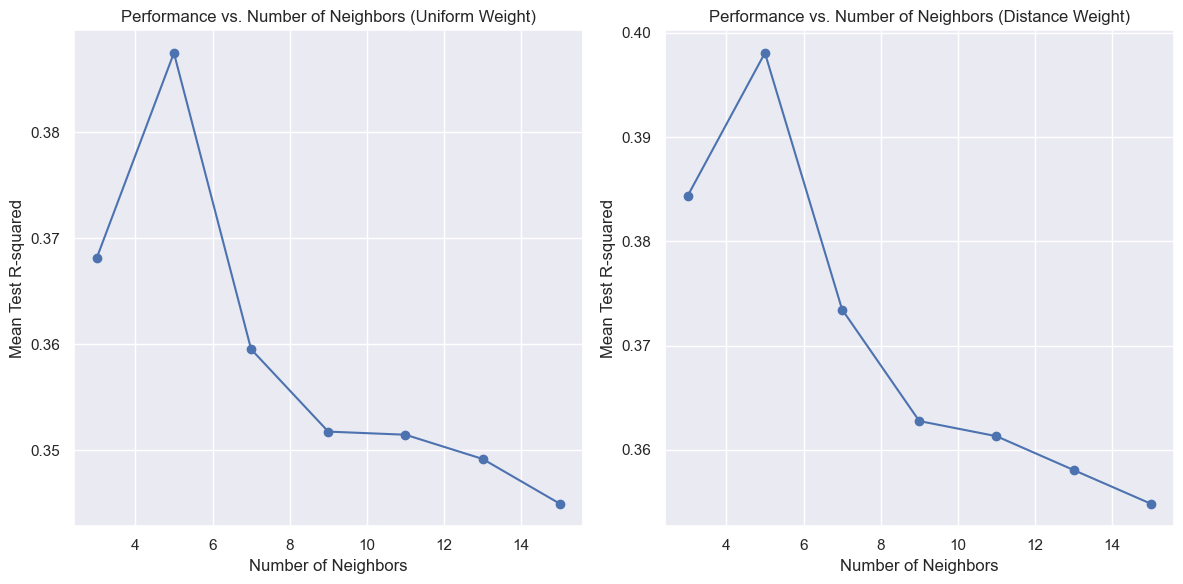

{'model': 'kNN', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.49123084567396347, 'r2_test_std': 0.0, 'rmse_test_moy': 12444978.940533362, 'rmse_test_std': 0.0, 'r2_train_moy': 1.0, 'r2_train_std': 0.0, 'rmse_train_moy': 0.0, 'rmse_train_std': 0.0, 'r2_val_moy': 0.39807855192197616, 'r2_val_std': 0.0, 'rmse_val_moy': 26575298.49155143, 'rmse_val_std': 0.0, 'time_fit_moy': 0.0076912660006200895, 'time_fit_std': 0.0, 'time_predict_moy': 0.011883647999638924, 'time_predict_std': 0.0} 



model    set                                 scaler  \
6   Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
4   Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
2   Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0   Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
14            kNN  data1  RobustScaler(quantile_range=(25, 75))   
12  Ridge (tuned)  data7  RobustScaler(quantile_range=(25, 75))   
7   Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
3   Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
9   Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
11  Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   
5   Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
1   Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
13  Ridge (tuned)  data7  RobustScaler(quantile_range=(25, 75))   
8   Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
10  Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   

                 target  r2_test_moy  r2_test_std  rmse_test_moy  \
6   SiteEnergyUse(kBtu)     0.581915          0.0   1.128148e+07   
4   SiteEnergyUse(kBtu)     0.503646          0.0   1.229220e+07   
2   SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0   SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
14  SiteEnergyUse(kBtu)     0.491231          0.0   1.244498e+07   
12  SiteEnergyUse(kBtu)     0.488408          0.0   1.247946e+07   
7      SiteEUI(kBtu/sf)     0.346450          0.0   4.434084e+01   
3      SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
9      SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
11     SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
5      SiteEUI(kBtu/sf)     0.311591          0.0   4.550798e+01   
1      SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   
13     SiteEUI(kBtu/sf)     0.304033          0.0   4.575713e+01   
8   SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   
10  SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   

    rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
6             0.0      0.773800           0.0    1.544445e+07             0.0   
4             0.0      0.770988           0.0    1.554016e+07             0.0   
2             0.0      0.769322           0.0    1.559659e+07             0.0   
0             0.0      0.770385           0.0    1.556063e+07             0.0   
14            0.0      1.000000           0.0    0.000000e+00             0.0   
12            0.0      0.771066           0.0    1.553753e+07             0.0   
7             0.0      0.351299           0.0    6.210393e+01             0.0   
3             0.0      0.345371           0.0    6.238705e+01             0.0   
9             0.0      0.357973           0.0    6.178361e+01             0.0   
11            0.0      0.357973           0.0    6.178361e+01             0.0   
5             0.0      0.358582           0.0    6.175431e+01             0.0   
1             0.0      0.358301           0.0    6.176782e+01             0.0   
13            0.0      0.359992           0.0    6.168640e+01             0.0   
8             0.0      0.459565           0.0    2.387251e+07             0.0   
10            0.0      0.459565           0.0    2.387251e+07             0.0   

    r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
6     0.506400         0.0  1.723465e+07           0.0      0.007802   
4     0.531081         0.0  1.759874e+07           0.0      0.008488   
2     0.532717         0.0  1.753694e+07           0.0      0.006335   
0     0.530925         0.0  1.761892e+07           0.0      0.008953   
14    0.398079         0.0  2.657530e+07           0.0      0.007691   
12    0.529031         0.0  1.797558e+07           0.0      0.008413   
7     0.301147         0.0  6.483752e+01         

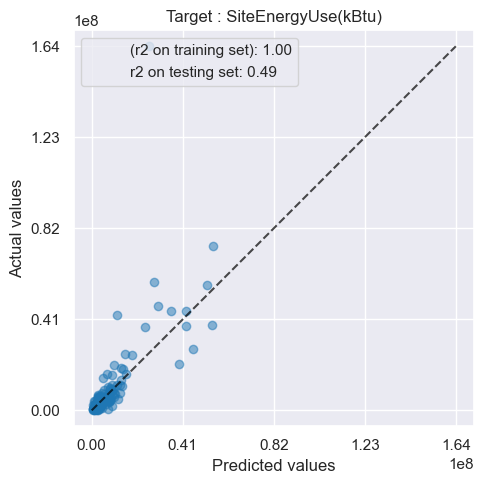

In [193]:
# Define the plotting function
def plot_performance_vs_neighbors(grid_search):
    # Extract the results from the GridSearchCV object
    results = grid_search.cv_results_
    
    # Extract the parameters and scores for both uniform and distance weights
    params_uniform = [param for param in results['params'][::2]]
    params_distance = [param for param in results['params'][1::2]]
    test_scores_uniform = results['mean_test_r2'][::2]
    test_scores_distance = results['mean_test_r2'][1::2]
    
    # Extract the parameter values for uniform and distance weights
    n_neighbors_uniform = [param['knn_regressor__n_neighbors'] for param in params_uniform]
    n_neighbors_distance = [param['knn_regressor__n_neighbors'] for param in params_distance]
    
    # Create separate plots for uniform and distance weights
    plt.figure(figsize=(12, 6))
    
    # Plot for uniform weight
    plt.subplot(1, 2, 1)
    plt.plot(n_neighbors_uniform, test_scores_uniform, marker='o', linestyle='-')
    plt.title("Performance vs. Number of Neighbors (Uniform Weight)")
    plt.xlabel("Number of Neighbors")
    plt.ylabel("Mean Test R-squared")
    plt.grid(True)
    
    # Plot for distance weight
    plt.subplot(1, 2, 2)
    plt.plot(n_neighbors_distance, test_scores_distance, marker='o', linestyle='-')
    plt.title("Performance vs. Number of Neighbors (Distance Weight)")
    plt.xlabel("Number of Neighbors")
    plt.ylabel("Mean Test R-squared")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def pipe_knn(alea, y, scaler, graph, metric):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Create a KNN Regressor
    knn_regressor = KNeighborsRegressor(metric=metric)

    # Create a pipeline with preprocessing and a knn regressor
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("knn_regressor", knn_regressor)
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'knn_regressor__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'knn_regressor__weights': ['uniform', 'distance']
    }

    # Create the GridSearchCV object with multiple scoring metrics
    scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}
    grid_search = GridSearchCV(pipe, param_grid=param_grid, 
                            scoring=scoring, cv=5, refit='r2', verbose=1)
    
    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Create the KNN regressor with the best hyperparameters
    best_knn_regressor = KNeighborsRegressor(metric=metric,
                                             n_neighbors=best_params['knn_regressor__n_neighbors'],
                                             weights=best_params['knn_regressor__weights'])

    # Create a pipeline with the preprocessor and the tuned knn regressor
    pipeline_with_tuned_knn = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("knn_regressor", best_knn_regressor)  # Use the tuned neighbor and weight values here
    ])

    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_knn, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_knn, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_knn, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_knn.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_performance_vs_neighbors(grid_search)
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_knn_n_times(y=y_E, scaler=robust, graph=False, metric='euclidean'):
    print(f'Modèle : kNN')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_knn(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph,
                                                                                      metric=metric)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'kNN',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)

test_knn_n_times(scaler=robust, graph=True)
# test_knn_n_times(y=y_EI, scaler=robust, graph=True)

affichage_results()

# 0.4, ce qui est bien, mais pas top.
# dataset trop petit pour un knn ? (relativement peu d'individus)


### 4.2 regression linéaire (multiple)

Modèle : Linear
target :  SiteEnergyUse(kBtu)
Iteration  1
Cross-Validation Scores:
Split 1 : r2 = 0.6946590464196765
Split 2 : r2 = 0.6735380456120297
Split 3 : r2 = 0.1586459474369265
Split 4 : r2 = 0.19095788185593154
Split 5 : r2 = 0.884793673341982
R-squared (val) =  0.5205189189333093
R-squared (train) =  0.7710673575700084
R-squared (test) =  0.4804526886001109
RMSE (val) =  18294095.55669051
RMSE (train) =  15537473.889626106
RMSE (test) =  12576110.087325618

{'model': 'Linear', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.4804526886001109, 'r2_test_std': 0.0, 'rmse_test_moy': 12576110.087325618, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7710673575700084, 'r2_train_std': 0.0, 'rmse_train_moy': 15537473.889626106, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5205189189333093, 'r2_val_std': 0.0, 'rmse_val_moy': 18294095.55669051, 'rmse_val_std': 0.0, 'time_fit_moy': 0.01344997599881026, 'time_fit_std': 0.0, 'time_pred

model    set                                 scaler  \
6   Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
4   Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
2   Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0   Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
14            kNN  data1  RobustScaler(quantile_range=(25, 75))   
12  Ridge (tuned)  data7  RobustScaler(quantile_range=(25, 75))   
15         Linear  data1  RobustScaler(quantile_range=(25, 75))   
7   Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
3   Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
9   Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
11  Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   
5   Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
1   Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
13  Ridge (tuned)  data7  RobustScaler(quantile_range=(25, 75))   
8   Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
10  Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   

                 target  r2_test_moy  r2_test_std  rmse_test_moy  \
6   SiteEnergyUse(kBtu)     0.581915          0.0   1.128148e+07   
4   SiteEnergyUse(kBtu)     0.503646          0.0   1.229220e+07   
2   SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0   SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
14  SiteEnergyUse(kBtu)     0.491231          0.0   1.244498e+07   
12  SiteEnergyUse(kBtu)     0.488408          0.0   1.247946e+07   
15  SiteEnergyUse(kBtu)     0.480453          0.0   1.257611e+07   
7      SiteEUI(kBtu/sf)     0.346450          0.0   4.434084e+01   
3      SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
9      SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
11     SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
5      SiteEUI(kBtu/sf)     0.311591          0.0   4.550798e+01   
1      SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   
13     SiteEUI(kBtu/sf)     0.304033          0.0   4.575713e+01   
8   SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   
10  SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   

    rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
6             0.0      0.773800           0.0    1.544445e+07             0.0   
4             0.0      0.770988           0.0    1.554016e+07             0.0   
2             0.0      0.769322           0.0    1.559659e+07             0.0   
0             0.0      0.770385           0.0    1.556063e+07             0.0   
14            0.0      1.000000           0.0    0.000000e+00             0.0   
12            0.0      0.771066           0.0    1.553753e+07             0.0   
15            0.0      0.771067           0.0    1.553747e+07             0.0   
7             0.0      0.351299           0.0    6.210393e+01             0.0   
3             0.0      0.345371           0.0    6.238705e+01             0.0   
9             0.0      0.357973           0.0    6.178361e+01             0.0   
11            0.0      0.357973           0.0    6.178361e+01             0.0   
5             0.0      0.358582           0.0    6.175431e+01             0.0   
1             0.0      0.358301           0.0    6.176782e+01             0.0   
13            0.0      0.359992           0.0    6.168640e+01             0.0   
8             0.0      0.459565           0.0    2.387251e+07             0.0   
10            0.0      0.459565           0.0    2.387251e+07             0.0   

    r2_val_moy  r2_val_std  rmse_val_moy  rmse_val_std  time_fit_moy  \
6     0.506400         0.0  1.723465e+07           0.0      0.007802   
4     0.531081         0.0  1.759874e+07           0.0      0.008488   
2     0.532717         0.0  1.753694e+07           0.0      0.006335   
0     0.530925         0.0  1.761892e+07         

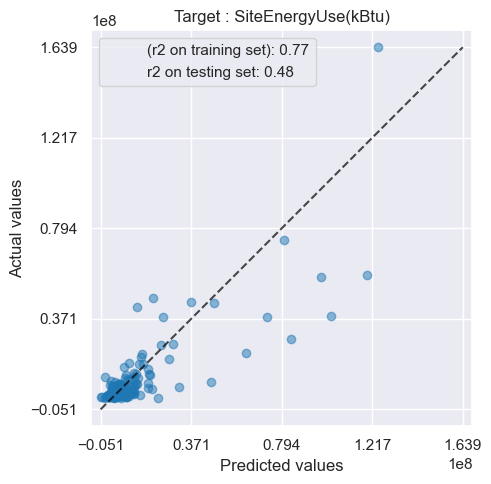

In [194]:
# juste pour vérifier qu'on retrouve ridge avec alpha nul :
# to describe the dataset as a linear model we use a ridge regressor with a very small regularization

# "Coefficients in multiple linear models represent the relationship between the given feature
# and the target, assuming that all the other features remain constant (conditional dependence)."

def pipe_linear(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("linear_regressor", LinearRegression())
        ])

    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_linear_n_times(y=y_E, scaler=robust, graph=False):
    print(f'Modèle : Linear')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_linear(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Linear',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)

test_linear_n_times(scaler=robust, graph=True)
# test_knn_n_times(y=y_EI, scaler=robust, graph=True)

affichage_results()

# 0.4, ce qui est bien, mais pas top.
# dataset trop petit pour un knn ? (relativement peu d'individus)


### 4.3 Ridge avec chemin de régularisation 

In [195]:
# juste pour observer les effets de la régularisation de la fonction de perte
# (= influence de la valeur d'alpha)

# A la main 

def pipe_ridge_alpha(alea, y, scaler, graph, alpha):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ridge_regressor", Ridge(alpha=alpha))
    ])

    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_ridge_alpha_n_times(alpha, y=y_E, scaler=robust, graph=False):
    print(f'Modèle : Ridge, alpha = ' + str(alpha))
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_ridge_alpha(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph,
                                                                                      alpha=alpha)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Ridge, alpha = ' +str(alpha),
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)

test_ridge_alpha_n_times(y=y_E, scaler=robust, alpha=0)
test_ridge_alpha_n_times(y=y_E, scaler=robust, alpha=0.001)
test_ridge_alpha_n_times(y=y_E, scaler=robust, alpha=0.01)
test_ridge_alpha_n_times(y=y_E, scaler=robust, alpha=0.1)
test_ridge_alpha_n_times(y=y_E, scaler=robust, alpha=100)
test_ridge_alpha_n_times(y=y_E, scaler=robust, alpha=1000)
test_ridge_alpha_n_times(y=y_E, scaler=robust, alpha=1000000)

affichage_results()



Modèle : Ridge, alpha = 0
target :  SiteEnergyUse(kBtu)
Iteration  1
Cross-Validation Scores:
Split 1 : r2 = 0.6952357234492845
Split 2 : r2 = 0.6738003476433228
Split 3 : r2 = 0.1581248233537389
Split 4 : r2 = 0.19293556015075508
Split 5 : r2 = 0.8848920059707552
R-squared (val) =  0.5209976921135713
R-squared (train) =  0.7710570945019922
R-squared (test) =  0.48175321513531244
RMSE (val) =  18288839.655863073
RMSE (train) =  15537822.158799304
RMSE (test) =  12560360.01738175

{'model': 'Ridge, alpha = 0', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.48175321513531244, 'r2_test_std': 0.0, 'rmse_test_moy': 12560360.01738175, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7710570945019922, 'r2_train_std': 0.0, 'rmse_train_moy': 15537822.158799304, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5209976921135713, 'r2_val_std': 0.0, 'rmse_val_moy': 18288839.655863073, 'rmse_val_std': 0.0, 'time_fit_moy': 0.009247414000128629, 'time_f

model    set                                 scaler  \
6            Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
4            Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
2            Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
0            Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
14                     kNN  data1  RobustScaler(quantile_range=(25, 75))   
12           Ridge (tuned)  data7  RobustScaler(quantile_range=(25, 75))   
19      Ridge, alpha = 0.1  data1  RobustScaler(quantile_range=(25, 75))   
18     Ridge, alpha = 0.01  data1  RobustScaler(quantile_range=(25, 75))   
17    Ridge, alpha = 0.001  data1  RobustScaler(quantile_range=(25, 75))   
16        Ridge, alpha = 0  data1  RobustScaler(quantile_range=(25, 75))   
15                  Linear  data1  RobustScaler(quantile_range=(25, 75))   
7            Ridge (tuned)  data4  RobustScaler(quantile_range=(25, 75))   
3            Ridge (tuned)  data2  RobustScaler(quantile_range=(25, 75))   
20      Ridge, alpha = 100  data1  RobustScaler(quantile_range=(25, 75))   
11           Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   
9            Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   
5            Ridge (tuned)  data3  RobustScaler(quantile_range=(25, 75))   
1            Ridge (tuned)  data1  RobustScaler(quantile_range=(25, 75))   
13           Ridge (tuned)  data7  RobustScaler(quantile_range=(25, 75))   
21     Ridge, alpha = 1000  data1  RobustScaler(quantile_range=(25, 75))   
22  Ridge, alpha = 1000000  data1  RobustScaler(quantile_range=(25, 75))   
10           Ridge (tuned)  data6  RobustScaler(quantile_range=(25, 75))   
8            Ridge (tuned)  data5  RobustScaler(quantile_range=(25, 75))   

                 target  r2_test_moy  r2_test_std  rmse_test_moy  \
6   SiteEnergyUse(kBtu)     0.581915          0.0   1.128148e+07   
4   SiteEnergyUse(kBtu)     0.503646          0.0   1.229220e+07   
2   SiteEnergyUse(kBtu)     0.500645          0.0   1.232930e+07   
0   SiteEnergyUse(kBtu)     0.499173          0.0   1.234746e+07   
14  SiteEnergyUse(kBtu)     0.491231          0.0   1.244498e+07   
12  SiteEnergyUse(kBtu)     0.488408          0.0   1.247946e+07   
19  SiteEnergyUse(kBtu)     0.484251          0.0   1.253006e+07   
18  SiteEnergyUse(kBtu)     0.482013          0.0   1.255721e+07   
17  SiteEnergyUse(kBtu)     0.481779          0.0   1.256005e+07   
16  SiteEnergyUse(kBtu)     0.481753          0.0   1.256036e+07   
15  SiteEnergyUse(kBtu)     0.480453          0.0   1.257611e+07   
7      SiteEUI(kBtu/sf)     0.346450          0.0   4.434084e+01   
3      SiteEUI(kBtu/sf)     0.339611          0.0   4.457221e+01   
20  SiteEnergyUse(kBtu)     0.328507          0.0   1.429732e+07   
11     SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
9      SiteEUI(kBtu/sf)     0.321410          0.0   4.518227e+01   
5      SiteEUI(kBtu/sf)     0.311591          0.0   4.550798e+01   
1      SiteEUI(kBtu/sf)     0.307232          0.0   4.565185e+01   
13     SiteEUI(kBtu/sf)     0.304033          0.0   4.575713e+01   
21  SiteEnergyUse(kBtu)     0.275924          0.0   1.484656e+07   
22  SiteEnergyUse(kBtu)     0.036237          0.0   1.712848e+07   
10  SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   
8   SiteEnergyUse(kBtu)    -0.478570          0.0   2.121557e+07   

    rmse_test_std  r2_train_moy  r2_train_std  rmse_train_moy  rmse_train_std  \
6             0.0      0.773800           0.0    1.544445e+07             0.0   
4             0.0      0.770988           0.0    1.554016e+07             0.0   
2             0.0      0.769322           0.0    1.559659e+07             0.0   
0             0.0      0.770385           0.0    1.556063e+07             0.0   
14            0.0      1.000000           0.0    0.000000e+00             0.0   
12            0.0      0.771066           0.0    1.553753e+07             0.0

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'G

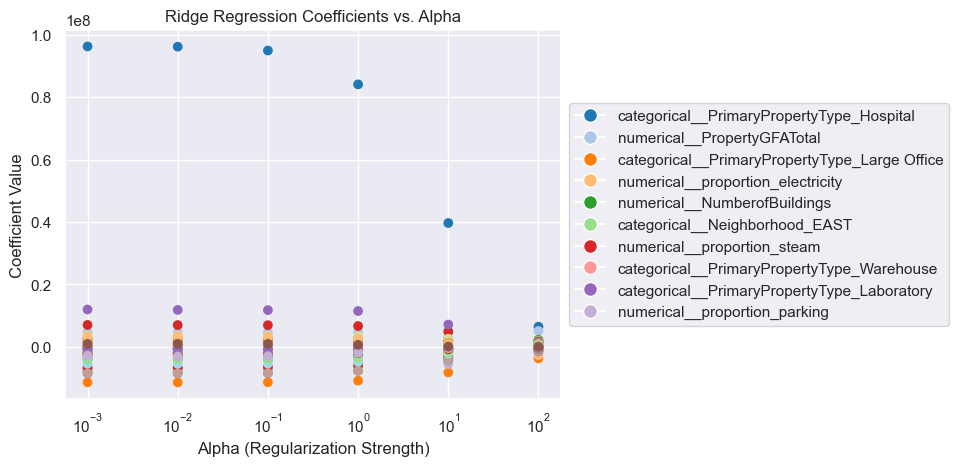

In [196]:
# Avec gridsearchcv

print(plt.colormaps())

if 'tab20' in plt.colormaps():
    print('it is')
else:
    print('nope')


alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100]

def plot_ridge_regression_path(y=y_E, alphas=alphas, input_features=cat+num):
    # Create an array to store the coefficients for each alpha
    coefs = []
    feature_names = None
    top_feature_names = []

    for alpha in alphas:
        # Séparation des jeux de données entrainement / validation, preprocessing
        X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=42, test_size=test_size, \
                                                                        scaler=robust)
        
        # Fit and transform the preprocessor on the training data to get post-preprocessing feature names
        X_train_transformed = preprocessor.fit_transform(X_train)
        
        # Get the feature names for the transformed data
        feature_names = preprocessor.get_feature_names_out(input_features)
 
        # Create a pipeline for the current alpha
        pipe_path = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("ridge_regressor", Ridge(alpha=alpha))
        ])

        # Fit the pipeline
        pipe_path.fit(X_train, y_train)

        # Get the coefficients for the current alpha
        coefficients = pipe_path.named_steps['ridge_regressor'].coef_
        coefs.append(coefficients)

    # Get the feature names with the largest coefficients across alphas
    top_feature_indices = np.argsort(np.abs(coefs[-1]))[::-1]  # Sort in descending order

    if feature_names is not None:
        # Check if the number of feature names matches the number of coefficients
        if len(feature_names) == len(coefs[0]):
            top_feature_names = [feature_names[i] for i in top_feature_indices]
        else:
            print("Mismatch between feature names and coefficients dimensions.")
            top_feature_names = None
    else:
        top_feature_names = None

    ax = plt.gca()

    # Define a custom colormap for feature colors
    cmap = plt.colormaps.get_cmap('tab20')

    # Get the unique colors for each feature
    feature_colors = [cmap(i % 20) for i in range(len(top_feature_indices))]

    # Plot the coefficients for the top features across alphas with feature-based colors
    for i, alpha in enumerate(alphas):
        feature_coefficients = [coefs[i][j] for j in top_feature_indices]
        ax.scatter([alpha] * len(top_feature_indices), feature_coefficients, color=feature_colors)

    plt.xlabel('Alpha (Regularization Strength)')
    plt.ylabel('Coefficient Value')
    plt.title('Ridge Regression Coefficients vs. Alpha')

    plt.xticks(alphas)

    # Sort the top feature names by coefficient magnitude (absolute value)
    sorted_top_feature_names = [top_feature_names[i] for i in np.argsort(np.abs(coefs[-1][top_feature_indices]))[::-1]]

    if len(top_feature_names) > 0:
        # Create a legend with feature names and corresponding colors
        # Show only the top ten features in the legend
        legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=feature_colors[i], markersize=10, label=sorted_top_feature_names[i]) for i in range(min(10, len(sorted_top_feature_names)))]
        plt.legend(handles=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))  # Display top ten feature names in the legend

    plt.grid(True)
    plt.xscale('log')
    plt.show()

plot_ridge_regression_path(y=y_E, alphas=alphas, input_features=cat+num)


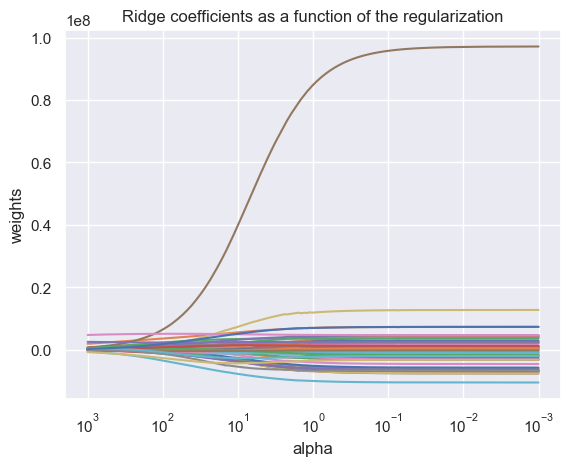

In [197]:
# code + élégant (adapté de scikit doc)

n_alphas = 200
alphas = np.logspace(-3, 3, n_alphas)

coefs = []
for a in alphas:
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y=y_E, alea=42, test_size=test_size, \
                                                                        scaler=robust)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ridge_regressor", Ridge(alpha=a, fit_intercept=False))
        ])
    pipe.fit(X_train, y_train)

    coefficients = pipe.named_steps['ridge_regressor'].coef_
    coefs.append(coefficients)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()


In [198]:
def pipe_ridge_fine_tuning(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge_regressor", Ridge())
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'ridge_regressor__alpha': np.logspace(-2, 2, 100)
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters and best estimator
    best_alpha = grid_search.best_params_['ridge_regressor__alpha']
    # best_estimator = grid_search.best_estimator_
    print(f"Best alpha: {best_alpha}")

    # Create a pipeline with the preprocessor and the tuned Ridge regressor
    pipeline_with_tuned_ridge = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ridge_regressor", Ridge(alpha=best_alpha))  # Use the tuned alpha value here
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_ridge, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_ridge, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_ridge, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_ridge.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict, best_alpha


def test_ridge_fine_tuning_n_times(y=y_E, scaler=None, graph=False):
    print(f'Modèle : Ridge_fine_tuned')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []
    best_alphas = []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict, best_alpha = pipe_ridge_fine_tuning(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)
        best_alphas.append(best_alpha)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)
    best_alpha_moy = np.mean(best_alphas)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Ridge, ba=' + str(best_alpha_moy),
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)

test_ridge_fine_tuning_n_times(scaler=robust)
test_ridge_fine_tuning_n_times(y=y_EI, scaler=robust)


affichage_results()

# r2 n'augmente pas, le tuning est suffisamment fin.


Modèle : Ridge_fine_tuned
target :  SiteEnergyUse(kBtu)
Iteration  1
Best alpha: 2.2051307399030455
Cross-Validation Scores:
Split 1 : r2 = 0.6883984806818406
Split 2 : r2 = 0.6628432903257853
Split 3 : r2 = 0.1607681652534848
Split 4 : r2 = 0.21201834142041198
Split 5 : r2 = 0.9416036809366373
R-squared (val) =  0.5331263917236321
R-squared (train) =  0.7686088180306723
R-squared (test) =  0.5043702278167151
RMSE (val) =  17265995.836708795
RMSE (train) =  15620680.642262204
RMSE (test) =  12283226.85219747

{'model': 'Ridge, ba=2.2051307399030455', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.5043702278167151, 'r2_test_std': 0.0, 'rmse_test_moy': 12283226.85219747, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7686088180306723, 'r2_train_std': 0.0, 'rmse_train_moy': 15620680.642262204, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5331263917236321, 'r2_val_std': 0.0, 'rmse_val_moy': 17265995.836708795, 'rmse_val_std': 0.0, 'tim

model    set  \
6                  Ridge (tuned)  data4   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
2                  Ridge (tuned)  data2   
0                  Ridge (tuned)  data1   
14                           kNN  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
8                  Ridge (tuned)  data5   
10                 Ridge (tuned)  data6   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   

    r2_test_std  rmse_test_moy  rmse_test_std  r2_train_moy  r2_train_std  \
6           0.0   1.128148e+07            0.0      0.773800           0.0   
23          0.0   1.228323e+07            0.0      0.768609           0.0   
4           0.0   1.229220e+07            0.0      0.770988           0.0   
2           0.0   1.232930e+07            0.0      0.769322           0.0   
0           0.0   1.234746e+07            0.0      0.770385           0.0   
14          0.0   1.244498e+07            0.0      1.000000           0.0   
12          0.0   1.247946e+07            0.0      0.771066           0.0   
19          0.0   1.253006e+07            0.0      0.771048           0.0   
18          0.0   1.255721e+07            0.0      0.771057           0.0   
17          0.0   1.256005e+07            0.0      0.771057           0.0   
16    

### 4.4 Bayesian ridge 

In [199]:
def pipe_bayesian_tuned(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("bayesian_regressor", BayesianRidge())
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'bayesian_regressor__max_iter': [100, 200, 300],
        'bayesian_regressor__alpha_1': [1e-6, 1e-5, 1e-4],
        'bayesian_regressor__alpha_2': [1e-6, 1e-5, 1e-4],
        'bayesian_regressor__lambda_1': [1e-6, 1e-5, 1e-4],
        'bayesian_regressor__lambda_2': [1e-6, 1e-5, 1e-4]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best parameters
    best_max_iter = grid_search.best_params_['bayesian_regressor__max_iter']
    best_alpha_1 = grid_search.best_params_['bayesian_regressor__alpha_1']
    best_alpha_2 = grid_search.best_params_['bayesian_regressor__alpha_2']
    best_lambda_1 = grid_search.best_params_['bayesian_regressor__lambda_1']
    best_lambda_2 = grid_search.best_params_['bayesian_regressor__lambda_2']

    # Create a pipeline with the preprocessor and the tuned Ridge regressor
    pipeline_with_tuned_ridge = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("bayesian_regressor", BayesianRidge(max_iter=best_max_iter,
        alpha_1=best_alpha_1, 
        alpha_2=best_alpha_2, 
        lambda_1=best_lambda_1, 
        lambda_2=best_lambda_2))  
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_ridge, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_ridge, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_ridge, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_ridge.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_bayesian_tuned_n_times(y=y_E, scaler=None, graph=False):
    print(f'Modèle : Bayesian_tuned')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_bayesian_tuned(alea=n, 
                                                                                                              y=y, 
                                                                                                              scaler=scaler,
                                                                                                              graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Bayesian (tuned)',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }               
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# test_bayesian_tuned_n_times(scaler=MinMaxScaler(), graph=True)
# test_bayesian_tuned_n_times(y=y_EI, scaler=MinMaxScaler(), graph=True)

# ne fonctionne pas
# ??


### 4.5 Lasso 

In [200]:
def plot_lasso_regression_path(X_train, y_train, preprocessor, alphas, feature_names=None):
    # Create an array to store the coefficients for each alpha
    coefs = []

    for alpha in alphas:
        # Create a pipeline for the current alpha
        pipe_path = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("lasso_regressor", Lasso(alpha=alpha))
        ])

        # Fit the pipeline
        pipe_path.fit(X_train, y_train)

        # Get the coefficients for the current alpha
        coefficients = pipe_path.named_steps['lasso_regressor'].coef_
        coefs.append(coefficients)

    # Get the feature names with the largest coefficients across alphas
    top_feature_indices = np.argsort(np.abs(coefs[-1]))[::-1]  # Sort in descending order

    if feature_names is not None:
        # Check if the number of feature names matches the number of coefficients
        if len(feature_names) == len(coefs[0]):
            top_feature_names = [feature_names[i] for i in top_feature_indices]
        else:
            print("Mismatch between feature names and coefficients dimensions.")
            top_feature_names = None
    else:
        top_feature_names = None

    ax = plt.gca()

    # Define a custom colormap for feature colors
    cmap = plt.colormaps.get_cmap('tab20')

    # Get the unique colors for each feature
    feature_colors = [cmap(i % 20) for i in range(len(top_feature_indices))]

    # Plot the coefficients for the top features across alphas with feature-based colors
    for i, alpha in enumerate(alphas):
        feature_coefficients = [coefs[i][j] for j in top_feature_indices]
        ax.scatter([alpha] * len(top_feature_indices), feature_coefficients, color=feature_colors)

    plt.xlabel('Alpha (Regularization Strength)')
    plt.ylabel('Coefficient Value')
    plt.title('Lasso Regression Coefficients vs. Alpha')

    plt.xticks(alphas)

    # Sort the top feature names by coefficient magnitude (absolute value)
    sorted_top_feature_names = [top_feature_names[i] for i in np.argsort(np.abs(coefs[-1][top_feature_indices]))[::-1]]

    if top_feature_names:
        # Create a legend with feature names and corresponding colors
        # Show only the top ten features in the legend
        legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=feature_colors[i], markersize=10, label=sorted_top_feature_names[i]) for i in range(min(10, len(sorted_top_feature_names)))]
        plt.legend(handles=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))  # Display top ten feature names in the legend

    plt.grid(True)
    plt.xscale('log')
    plt.show()


Modèle : Lasso
target :  SiteEnergyUse(kBtu)
Iteration  1
Best alpha: 187381.74228603867
Cross-Validation Scores:
Split 1 : r2 = 0.6746784211052601
Split 2 : r2 = 0.6451915131640703
Split 3 : r2 = 0.168885643585713
Split 4 : r2 = 0.2350591555450876
Split 5 : r2 = 0.9592152294577532
R-squared (val) =  0.5366059925715769
R-squared (train) =  0.7519950124289765
R-squared (test) =  0.549112934516296
RMSE (val) =  16923226.02593678
RMSE (train) =  16171740.311089681
RMSE (test) =  11715684.506944302



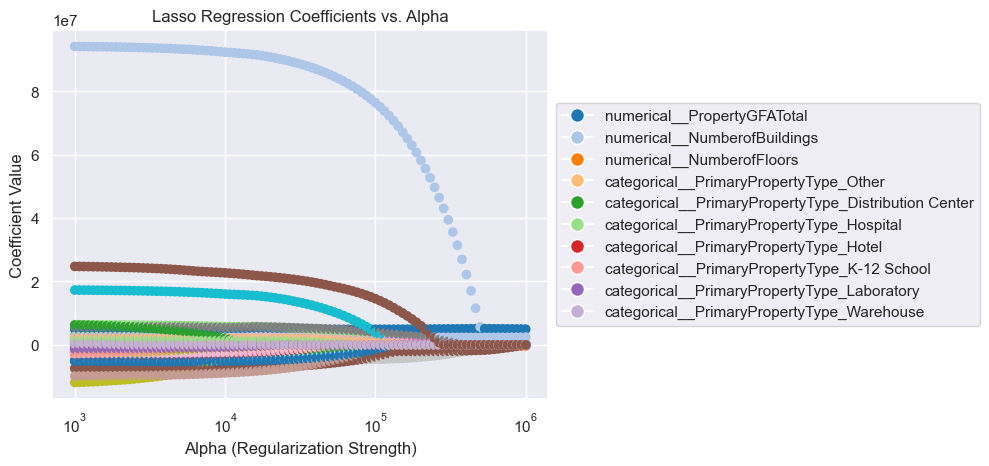

{'model': 'Lasso', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.549112934516296, 'r2_test_std': 0.0, 'rmse_test_moy': 11715684.506944302, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7519950124289765, 'r2_train_std': 0.0, 'rmse_train_moy': 16171740.311089681, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5366059925715769, 'r2_val_std': 0.0, 'rmse_val_moy': 16923226.02593678, 'rmse_val_std': 0.0, 'time_fit_moy': 0.011788079998950707, 'time_fit_std': 0.0, 'time_predict_moy': 0.003314556000987068, 'time_predict_std': 0.0} 



model    set  \
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
2                  Ridge (tuned)  data2   
0                  Ridge (tuned)  data1   
14                           kNN  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
9                  Ridge (tuned)  data5   
11                 Ridge (tuned)  data6   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   

    r2_test_std  rmse_test_moy  rmse_test_std  r2_train_moy  r2_train_std  \
6           0.0   1.128148e+07            0.0      0.773800           0.0   
25          0.0   1.171568e+07            0.0      0.751995           0.0   
23          0.0   1.228323e+07            0.0      0.768609           0.0   
4           0.0   1.229220e+07            0.0      0.770988           0.0   
2           0.0   1.232930e+07            0.0      0.769322           0.0   
0           0.0   1.234746e+07            0.0      0.770385           0.0   
14          0.0   1.244498e+07            0.0      1.000000           0.0   
12          0.0   1.247946e+07            0.0      0.771066           0.0   
19          0.0   1.253006e+07        

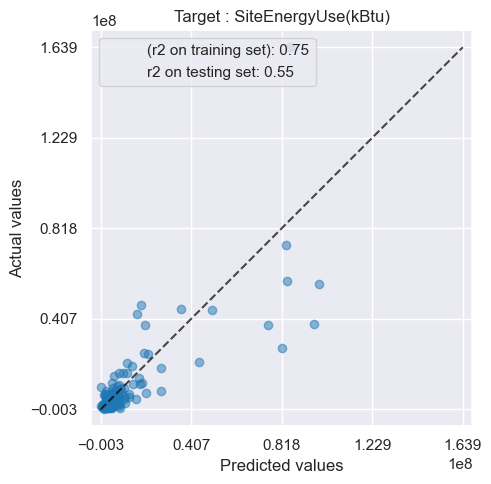

In [201]:
def pipe_lasso(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Fit and transform the preprocessor on the training data to get post-preprocessing feature names
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    # Get the feature names for the transformed data
    feature_names = preprocessor.get_feature_names_out(input_features=cat + num)

    # Define a list of alpha values for Lasso regression
    alphas = np.logspace(3, 6, 100)

    # Create a pipeline with preprocessing and LassoCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("lasso_regressor", LassoCV(alphas=alphas, cv=5, max_iter=100000))
    ])

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Access the best alpha value chosen by LassoCV
    best_alpha = pipe.named_steps['lasso_regressor'].alpha_
    print(f"Best alpha: {best_alpha}")

    # Create a pipeline with the preprocessor and the tuned Lasso regressor
    pipeline_with_tuned_lasso = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("lasso_regressor", Lasso(alpha=best_alpha, max_iter=100000))
    ])

    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_lasso, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)

    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_lasso, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_lasso, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_lasso.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_lasso_regression_path(X_train, y_train, preprocessor, alphas, feature_names)
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_lasso_n_times(y=y_E, scaler=robust, graph=False):
    print('Modèle : Lasso')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_lasso(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Lasso',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# Run the tuned Lasso regressor
test_lasso_n_times(y=y_E, scaler=robust, graph=True)

affichage_results()


### 4.6 elastic net


In [202]:
def plot_elastic_net_regression_path_3d(X_train, y_train, preprocessor, alphas, l1_ratios, feature_names=None):
    # Create arrays to store the coefficients and alphas
    coefs = []
    alphas_grid = np.tile(alphas, (len(l1_ratios), 1))  # Replicate alphas for each l1_ratio

    for l1_ratio in l1_ratios:
        l1_ratio_coefs = []  # Store coefficients for the current l1_ratio
        for alpha in alphas:
            # Create a pipeline for the current alpha and l1_ratio
            pipe_path = Pipeline(steps=[
                ("preprocessor", preprocessor),
                ("elastic_net_regressor", ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
            ])

            # Fit the pipeline
            pipe_path.fit(X_train, y_train)

            # Get the coefficients for the current alpha and l1_ratio
            coefficients = pipe_path.named_steps['elastic_net_regressor'].coef_
            l1_ratio_coefs.append(coefficients)

        coefs.append(l1_ratio_coefs)

    coefs = np.array(coefs)

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, l1_ratio in enumerate(l1_ratios):
        for j, alpha in enumerate(alphas):
            ax.plot([alpha] * len(coefs[i, j]), coefs[i, j], zs=l1_ratio, label=f'l1_ratio={l1_ratio}, alpha={alpha}')

    ax.set_xlabel('Alpha (Regularization Strength)')
    ax.set_ylabel('Coefficient Value')
    ax.set_zlabel('l1_ratio')
    ax.set_title('Elastic Net Coefficients vs. Alpha and l1_ratio')

    # Adjust subplot to make space for the z-axis label
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    # ax.legend()

    # plt.xscale('log')
    plt.show()

    # save the plot as an image
    # plt.savefig("elastic_net_regression_path_3d.png")


Modèle : Elastic net
target :  SiteEnergyUse(kBtu)
Iteration  1


Best alpha: 0.005179474679231213
Best l1_ratio: 0.1
Cross-Validation Scores:
Split 1 : r2 = 0.6672651907929171
Split 2 : r2 = 0.6275403937322828
Split 3 : r2 = 0.16311415716717526
Split 4 : r2 = 0.22406565395438083
Split 5 : r2 = 0.9571361385471019
R-squared (val) =  0.5278243068387716
R-squared (train) =  0.7607862412209772
R-squared (test) =  0.4893483409652818
RMSE (val) =  17074710.22134814
RMSE (train) =  15882527.972117672
RMSE (test) =  12467981.612695951



Objective did not converge. You might want to increase the number of iterations. Duality gap: 874978601121024.0, tolerance: 146894054768917.78
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.684326426958861e+16, tolerance: 146894054768917.78
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.684295763850067e+16, tolerance: 146894054768917.78
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.684269081352686e+16, tolerance: 146894054768917.78
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.684248564643494e+16, tolerance: 146894054768917.78
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.68423286131985e+16, tolerance: 146894054768917.78
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.684220548107971e+16, tolera

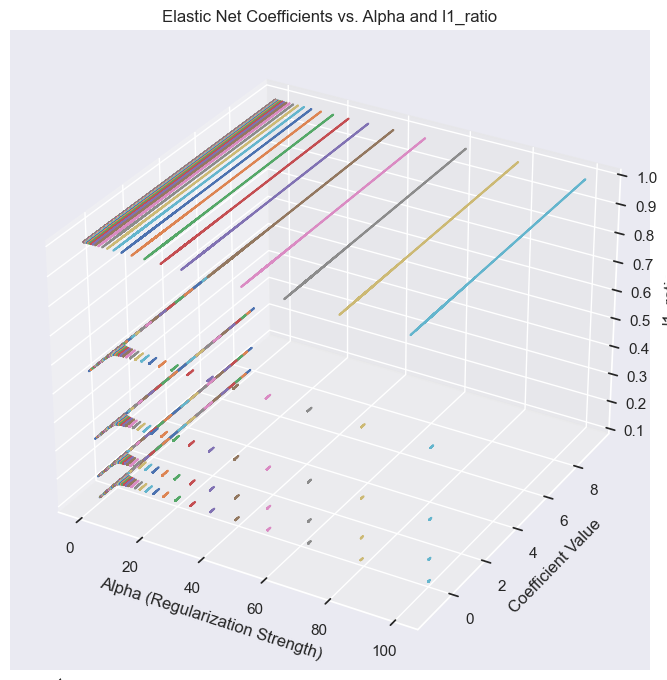

{'model': 'Elastic_net', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.4893483409652818, 'r2_test_std': 0.0, 'rmse_test_moy': 12467981.612695951, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7607862412209772, 'r2_train_std': 0.0, 'rmse_train_moy': 15882527.972117672, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5278243068387716, 'r2_val_std': 0.0, 'rmse_val_moy': 17074710.22134814, 'rmse_val_std': 0.0, 'time_fit_moy': 0.03836459200101672, 'time_fit_std': 0.0, 'time_predict_moy': 0.003482165000605164, 'time_predict_std': 0.0} 



model    set  \
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
2                  Ridge (tuned)  data2   
0                  Ridge (tuned)  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   

    r2_test_std  rmse_test_moy  rmse_test_std  r2_train_moy  r2_train_std  \
6           0.0   1.128148e+07            0.0      0.773800           0.0   
25          0.0   1.171568e+07            0.0      0.751995           0.0   
23          0.0   1.228323e+07            0.0      0.768609           0.0   
4           0.0   1.229220e+07            0.0      0.770988           0.0   
2           0.0   1.232930e+07            0.0      0.769322           0.0   
0           0.0   1.234746e+07            0.0      0.770385           0.0   
14          0.0   1.244498e+07            0.0      1.000000           

<Figure size 640x480 with 0 Axes>

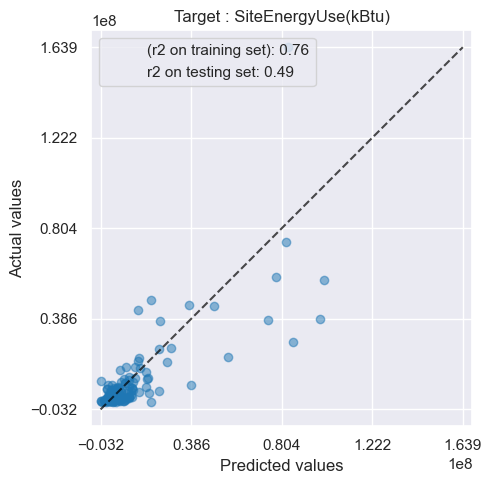

In [203]:
def pipe_elastic_net(alea, y, scaler, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Fit and transform the preprocessor on the training data to get post-preprocessing feature names
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    # Get the feature names for the transformed data
    feature_names = preprocessor.get_feature_names_out(input_features=cat + num)

    # Define a list of alpha values and l1_ratios for Elastic Net regression
    alphas = np.logspace(-3, 2, 50)
    l1_ratios = np.logspace(-1, 0, 5)

    # Create a pipeline with preprocessing and ElasticNetCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("elastic_net_regressor", ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, max_iter=10000))
    ])

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Access the best alpha value chosen by ElasticNetCV
    best_alpha = pipe.named_steps['elastic_net_regressor'].alpha_
    print(f"Best alpha: {best_alpha}")

    # Access the best l1_ratio chosen by ElasticNetCV
    best_l1_ratio = pipe.named_steps['elastic_net_regressor'].l1_ratio_
    print(f"Best l1_ratio: {best_l1_ratio}")

    # Create a pipeline with the preprocessor and the tuned Elastic Net regressor
    pipeline_with_tuned_elastic_net = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("elastic_net_regressor", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000))
    ])

    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_elastic_net, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)

    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_elastic_net, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_elastic_net, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_elastic_net.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_elastic_net_regression_path_3d(X_train, y_train, preprocessor, alphas, l1_ratios, feature_names)
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_elastic_net_n_times(y=y_E, scaler=robust, graph=False):
    print('Modèle : Elastic net')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_elastic_net(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Elastic_net',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# Run the tuned Lasso regressor
test_elastic_net_n_times(y=y_E, scaler=robust, graph=True)

affichage_results()


### 4.7 Polynomial regression

In [204]:
def pipe_polynomial(X=X, y=y_E, max_degree=3, model_results=model_results):

    print(f'Modèle : Polynomial (Degree {max_degree})')
    print('target : ', y.name)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    numeric_preprocessor = Pipeline(steps=[
        ("scaler", MinMaxScaler())
        ])
    
    categorical_preprocessor = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])
    
    preprocessor = ColumnTransformer([
        ("categorical", categorical_preprocessor, cat),
        ("numerical", numeric_preprocessor, num)
        ])
    
    # Fit and transform the preprocessor on the training data to get post-preprocessing feature names
    X_train_transformed = preprocessor.fit_transform(X_train)

    # Get the feature names for the transformed data
    feature_names = preprocessor.get_feature_names_out(input_features=cat + num)

    # Create an empty DataFrame to store coefficients
    coef_df = pd.DataFrame(columns=['Feature', 'Coefficient', 'Degree'])

    for degree in range(1, max_degree + 1):
        # Create polynomial features of the specified degree
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train_transformed)

        # Create a new pipeline for polynomial regression
        pipe = Pipeline(steps=[
            ("polynomial_features", poly),
            ("linear_regressor", LinearRegression())
        ])
        
        def fitting():
            pipe.fit(X_train_poly, y_train)

        fitting()
        execution_time_fit = timeit(fitting, number=1)
        print(f"time fit (Degree {degree}): {execution_time_fit}")

        # Transform the test data using the same polynomial features
        X_test_poly = poly.transform(preprocessor.transform(X_test))

        def predicting():
            return pipe.predict(X_test_poly)

        y_pred = predicting()
        execution_time_predict = timeit(predicting, number=1)
        print(f"time predict (Degree {degree}): {execution_time_predict}")

        r2 = r2_score(y_test, y_pred)
        print(f"R-squared (Degree {degree}): {r2}")
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print(f"RMSE (Degree {degree}): {rmse}", '\n')

        # Append a new row for this model 
        model_results.append({'Model': f'Polynomial (Degree {degree})',
                              'target': y.name, 
                              'R2': r2, 
                              'RMSE': rmse,
                              'time_fit': execution_time_fit,
                              'time_predict': execution_time_predict})
        
        # Get the coefficients from the linear model
        coefficients = pipe.named_steps['linear_regressor'].coef_
        
        # Create a DataFrame to store coefficients and feature names for this degree
        degree_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients, 'Degree': degree})

        # Sort the DataFrame
        degree_coef_df.sort_values(by='Coefficient', ascending=False, inplace=True)

        # Append to the overall coefficients DataFrame
        coef_df = coef_df.append(degree_coef_df, ignore_index=True)

    # Display the coefficients for all degrees
    display(coef_df)


# pipe_polynomial(X=X, y=y_E, max_degree=2)

# Même avec max_degree = 2, demande trop de memoire, + de 100 GiB
# Nécessite réduction dim (drastique)


### 4.8 linear SVR

In [205]:
def pipe_linear_SVR(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'linear_svr_regressor__C': [0.01, 0.1, 1.0, 10.0],
        'linear_svr_regressor__epsilon': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a pipeline with preprocessing and LassoCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("linear_svr_regressor", LinearSVR(dual=False, loss='squared_epsilon_insensitive'))
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_C = grid_search.best_params_['linear_svr_regressor__C']
    best_epsilon = grid_search.best_params_['linear_svr_regressor__epsilon']
    print(f"Best C: {best_C}")
    print(f"Best epsilon: {best_epsilon}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("linear_svr_regressor", LinearSVR(C=best_C, epsilon=best_epsilon, dual=False, loss='squared_epsilon_insensitive'))
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe_tuned, X_train, y_train, cv=5, scoring=scoring)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_linear_SVR_n_times(y=y_E, scaler=None, graph=False):
    print(f'Modèle : Linear SVR')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_linear_SVR(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Linear SVR',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_linear_SVR_n_times(scaler=robust)
# test_linear_SVR_n_times(y=y_EI, scaler=robust)


affichage_results()

# Second best


Modèle : Linear SVR
target :  SiteEnergyUse(kBtu)
Iteration  1
Best C: 0.1
Best epsilon: 0.1
Cross-Validation Scores:
Split 1 : r2 = 0.6692323102487647
Split 2 : r2 = 0.6303415211987875
Split 3 : r2 = 0.1618733729363201
Split 4 : r2 = 0.2260305133760504
Split 5 : r2 = 0.957705817016615
R-squared (val) =  0.5290367069553075
R-squared (train) =  0.763371741217772
R-squared (test) =  0.4995458954486093
RMSE (val) =  17054773.28285462
RMSE (train) =  15796463.025516596
RMSE (test) =  12342862.964024294

{'model': 'Linear SVR', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.4995458954486093, 'r2_test_std': 0.0, 'rmse_test_moy': 12342862.964024294, 'rmse_test_std': 0.0, 'r2_train_moy': 0.763371741217772, 'r2_train_std': 0.0, 'rmse_train_moy': 15796463.025516596, 'rmse_train_std': 0.0, 'r2_val_moy': 0.5290367069553075, 'r2_val_std': 0.0, 'rmse_val_moy': 17054773.28285462, 'rmse_val_std': 0.0, 'time_fit_moy': 0.013384971000050

model    set  \
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
8                  Ridge (tuned)  data5   
10                 Ridge (tuned)  data6   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   

    r2_test_std  rmse_test_moy  rmse_test_std  r2_train_moy  r2_train_std  \
6           0.0   1.128148e+07            0.0      0.773800           0.0   
25          0.0   1.171568e+07            0.0      0.751995           0.0   
23          0.0   1.228323e+07            0.0      0.768609           0.0   
4           0.0   1.229220e+07            0.0      0.770988           0.0   
2           0.0   1.232930e+07            0.0      0.769322           0.0   
27          0.0   1.23428

### 4.9 SVR à noyau rbf

Modèle : rbf kernel SVR
target :  SiteEnergyUse(kBtu)
Iteration  1


Best C: 10.0
Best epsilon: 0.01
Best gamma: 0.1
Cross-Validation Scores:
Split 1 : r2 = -0.06091371717256311
Split 2 : r2 = -0.07131598986224552
Split 3 : r2 = -0.04823479383348972
Split 4 : r2 = -0.05547867963267317
Split 5 : r2 = -0.02821703096279471
R-squared (val) =  -0.05283204229275325
R-squared (train) =  -0.0365524664490926
R-squared (test) =  -0.11891842902036953
RMSE (val) =  33076201.34064744
RMSE (train) =  33061472.772565607
RMSE (test) =  18455805.004119348

Gram Matrix (Kernel Matrix):


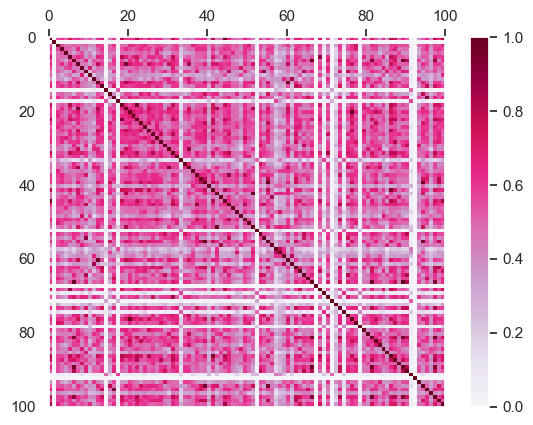

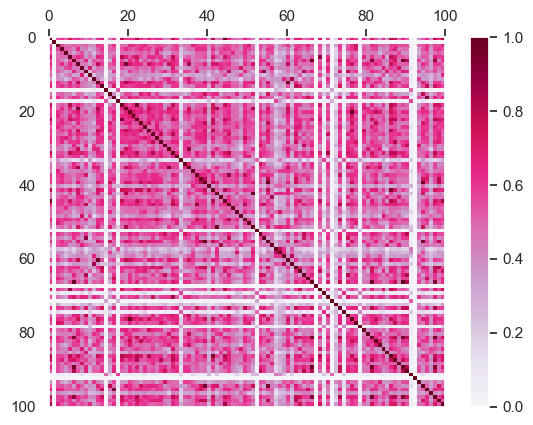

{'model': 'rbf kernel SVR', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': -0.11891842902036953, 'r2_test_std': 0.0, 'rmse_test_moy': 18455805.004119348, 'rmse_test_std': 0.0, 'r2_train_moy': -0.0365524664490926, 'r2_train_std': 0.0, 'rmse_train_moy': 33061472.772565607, 'rmse_train_std': 0.0, 'r2_val_moy': -0.05283204229275325, 'r2_val_std': 0.0, 'rmse_val_moy': 33076201.34064744, 'rmse_val_std': 0.0, 'time_fit_moy': 0.10262924899870995, 'time_fit_std': 0.0, 'time_predict_moy': 0.011460007997811772, 'time_predict_std': 0.0} 



model    set  \
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
28  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.118918   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   

    r2_test_std  rmse_test_moy  rmse_test_std  r2_train_moy  r2_train_std  \
6           0.0   1.128148e+07            0.0      0.773800           0.0   
25          0.0   1.171568e+07            0.0      0.751995           0.0   
23          0.0   1.228323e+07            0.0      0.768609           0.0   
4           0.0   1.229220e+07            0.0      0.7709

In [206]:
def gram_matrix(best_gamma, X_train_transformed):
     # Calculate the Gram matrix manually
    gram_matrix = np.exp(-best_gamma * pairwise_distances(X_train_transformed, metric='euclidean')**2)
    # display 100 max
    kmatrix100 = gram_matrix[:100, :100]
    print("Gram Matrix (Kernel Matrix):")
    # dessiner la matrice
    plt.pcolor(kmatrix100, cmap=plt.cm.PuRd) 
    # rajouter la légende
    plt.colorbar()
    # retourner l'axe des ordonnées
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    # afficher l'image
    plt.show()

    # Create the modified Gram matrix M
    diagonal = np.sqrt(np.diag(gram_matrix))
    M = gram_matrix / np.outer(diagonal, diagonal)
    # display 100 max
    M = M[:100, :100]
    # Display the modified Gram matrix M
    plt.pcolor(M, cmap=plt.cm.PuRd) 
    # rajouter la légende
    plt.colorbar()
    # retourner l'axe des ordonnées
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    # afficher l'image
    plt.show()

def pipe_rbf_kernel_SVR(alea, y, scaler, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Preprocess X_train to calculate the Gram matrix manually
    X_train_transformed = preprocessor.fit_transform(X_train)

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'rbf_svr_regressor__C': [0.01, 0.1, 1.0, 10.0],
        'rbf_svr_regressor__epsilon': [0.01, 0.1, 1.0, 10.0],
        'rbf_svr_regressor__gamma': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a pipeline with preprocessing and LassoCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("rbf_svr_regressor", SVR(kernel='rbf'))
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_C = grid_search.best_params_['rbf_svr_regressor__C']
    best_epsilon = grid_search.best_params_['rbf_svr_regressor__epsilon']
    best_gamma = grid_search.best_params_['rbf_svr_regressor__gamma']
    print(f"Best C: {best_C}")
    print(f"Best epsilon: {best_epsilon}")
    print(f"Best gamma: {best_gamma}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("rbf_svr_regressor", SVR(kernel='rbf', C=best_C, epsilon=best_epsilon, gamma=best_gamma))
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe_tuned, X_train, y_train, cv=5, scoring=scoring)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        gram_matrix(best_gamma, X_train_transformed)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_rbf_kernel_SVR_n_times(y=y_E, scaler=None, graph=False):
    print(f'Modèle : rbf kernel SVR')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_rbf_kernel_SVR(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'rbf kernel SVR',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_rbf_kernel_SVR_n_times(scaler=robust, graph=True)
# test_rbf_kernel_SVR_n_times(y=y_EI, scaler=robust)


affichage_results()

# pas un bon noyau pour mos données

# Matrices de Gram : la première matrice (tuned) et la seconde (data normalisée)
# sont assez diagonales, et les performances sont mauvaises.
# Ce modèle est mal adapté, ou notre data est mal formatée.


### 4.10 kRR

Modèle : rbf krr
target :  SiteEnergyUse(kBtu)
Iteration  1
Best alpha: 0.01
Best gamma: 0.01
Cross-Validation Scores:
Split 1 : r2 = 0.759897474443192
Split 2 : r2 = 0.8028525236983762
Split 3 : r2 = 0.20154710381946817
Split 4 : r2 = 0.17716323383903654
Split 5 : r2 = 0.08513441961298596
R-squared (val) =  0.4053189510826118
R-squared (train) =  0.9537309390972704
R-squared (test) =  0.5009406828360929
RMSE (val) =  28618652.536996916
RMSE (train) =  6985088.191632317
RMSE (test) =  12325650.914626572

Gram Matrix (Kernel Matrix):


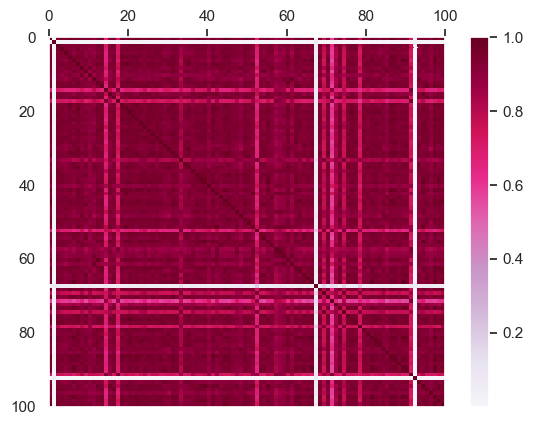

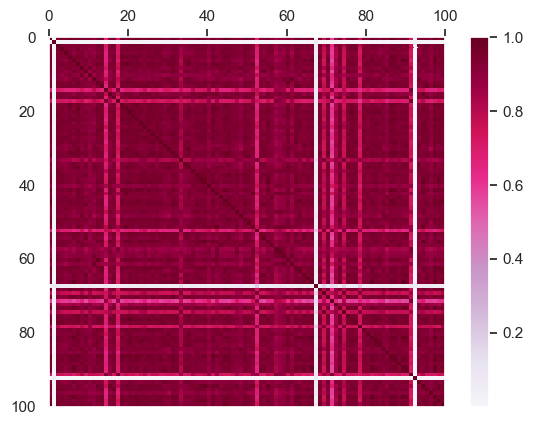

{'model': 'rbf krr', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.5009406828360929, 'r2_test_std': 0.0, 'rmse_test_moy': 12325650.914626572, 'rmse_test_std': 0.0, 'r2_train_moy': 0.9537309390972704, 'r2_train_std': 0.0, 'rmse_train_moy': 6985088.191632317, 'rmse_train_std': 0.0, 'r2_val_moy': 0.4053189510826118, 'r2_val_std': 0.0, 'rmse_val_moy': 28618652.536996916, 'rmse_val_std': 0.0, 'time_fit_moy': 0.09702848799861385, 'time_fit_std': 0.0, 'time_predict_moy': 0.011348923999321414, 'time_predict_std': 0.0} 



model    set  \
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
28  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.118918   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   

    r2_test_std  rmse_test_moy  rmse_test_std  r2_train_moy  r2_train_std  \
6           0.0   1.128148e+07            0.0      0.773800           0.0   
25          0.0   1.171568e+07            0.0      0.751995           0.0   
23          

In [207]:
# la SVR est plus rapide tandis que la kRR est plus efficace ?

def pipe_rbf_krr(alea, y, scaler, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Preprocess X_train to calculate the Gram matrix manually
    X_train_transformed = preprocessor.fit_transform(X_train)

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'krr_regressor__alpha': [0.01, 0.1, 1.0, 10.0],
        'krr_regressor__gamma': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a pipeline with preprocessing and LassoCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("krr_regressor", KernelRidge(kernel='rbf'))
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters and best estimator
    best_alpha = grid_search.best_params_['krr_regressor__alpha']
    best_gamma = grid_search.best_params_['krr_regressor__gamma']
    print(f"Best alpha: {best_alpha}")
    print(f"Best gamma: {best_gamma}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("krr_regressor", KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma))
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe_tuned, X_train, y_train, cv=5, scoring=scoring)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        gram_matrix(best_gamma, X_train_transformed)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_rbf_krr_n_times(y=y_E, scaler=None, graph=False):
    print(f'Modèle : rbf krr')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_rbf_krr(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'rbf krr',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_rbf_krr_n_times(scaler=robust, graph=True)
# test_rbf_krr_n_times(y=y_EI, scaler=robust)


affichage_results()

# Bcp + rapide que rbf kernel svr,
# pas de gain / linear tuned ridge

# Meilleur r2, Gram matrix plus étalée


Les modèles appris par la régression ridge et une SVR ont exactement la même forme, mais pas les mêmes coefficients. En effet, on a choisi d'optimiser des fonctions de perte différentes pour l'une et pour l'autre. Dans le cas de la régression ridge, on choisit de minimiser l'erreur quadratique entre la prédiction et la réalité. Pour la SVR, on utilise en fait une fonction de perte dite insensible à \epsilon, c'est à dire qu'elle vaut la valeur absolue de la différence entre la prédiction et la réalité, sauf si cette différence est faible, comprise entre −ϵ
 et ϵ
 , auquel cas on l'estime négligeable et la fonction de perte vaut 0.

En pratique, entraîner une kRR sera plus efficace car la solution est analytique est exacte ; prédire sera par contre plus rapide avec une SVR.

! Pas vérifié ici 

### 4.11 simple sequential neural network (3 layers)

In [208]:
def pipe_neural_network(alea, y=y_E, epochs=100, batch=30, scaler=robust):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_E, test_size=0.1, random_state=alea)

    # Define preprocessing for numerical and categorical data
    numeric_preprocessor = scaler
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

    # Scale numeric features and one-hot encode categorical features
    X_train_numeric = numeric_preprocessor.fit_transform(X_train[num])
    X_test_numeric = numeric_preprocessor.transform(X_test[num])
    X_train_categorical = categorical_preprocessor.fit_transform(X_train[cat])
    X_test_categorical = categorical_preprocessor.transform(X_test[cat])

    # Convert X_train_categorical to a dense NumPy array, same with X_test
    X_train_categorical_dense = X_train_categorical.toarray()
    X_test_categorical_dense = X_test_categorical.toarray()

    # Concatenate the preprocessed features

    X_test_processed = np.hstack((X_test_numeric, X_test_categorical_dense))
    X_train_processed = np.hstack((X_train_numeric, X_train_categorical_dense))

    # Define a simple 3-layer neural network using Keras Sequential API
    model = keras.Sequential([
        keras.layers.Dense(X_test_processed.shape[1], activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Output layer with a single neuron (for regression)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # fit model on training set 
    start_time_fit = timeit.default_timer()
    model.fit(X_train_processed, y_train, epochs=epochs, batch_size=batch, verbose=1)
    time_fit = timeit.default_timer() - start_time_fit
        
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(model, X_test_processed)    

    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, model.predict(X_train_processed))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_neural_network_n_times(y=y_E, scaler=robust, graph=True):
    print('Modèle : neural network')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_neural_network(alea=n)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'neural network',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# test_neural_network_n_times(y=y_E)

affichage_results()

# Il faudrait bcp + de tps pour entrainer efficacement un réseau neuronal,
# et le notebook n'est pas l'environnement le mieux adapté


model    set  \
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
28  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.118918   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   

    r2_test_std  rmse_test_moy  rmse_test_std  r2_train_moy  r2_train_std  \
6           0.0   1.128148e+07            0.0      0.773800           0.0   
25          0.0   1.171568e+07            0.0      0.751995           0.0   
23          

### 4.12 méthodes ensemblistes parallèles : bagging

Bagging, or Bootstrap Aggregating, is commonly used with models that exhibit high variance, which means they are sensitive to fluctuations in the training data. Linear regression models, which are generally low-variance models, might not be the most suitable candidates for bagging because they tend to underfit rather than overfit. Bagging typically works best with models like decision trees, which have higher variance.

Modèle : bagging Ridge()
target :  SiteEnergyUse(kBtu)
Iteration  1
R-squared (train) =  0.7661665087348877
R-squared (test) =  0.5156369430091741
RMSE (train) =  15702901.564219534
RMSE (test) =  12142812.395295402



{'model': 'bagg Ridge()', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.5156369430091741, 'r2_test_std': 0.0, 'rmse_test_moy': 12142812.395295402, 'rmse_test_std': 0.0, 'r2_train_moy': 0.7661665087348877, 'r2_train_std': 0.0, 'rmse_train_moy': 15702901.564219534, 'rmse_train_std': 0.0, 'time_fit_moy': 0.18352021299870103, 'time_fit_std': 0.0, 'time_predict_moy': 0.007813117001205683, 'time_predict_std': 0.0} 

Modèle : bagging LinearRegression()
target :  SiteEnergyUse(kBtu)
Iteration  1
R-squared (train) =  0.761702105278641
R-squared (test) =  0.49523160108970843
RMSE (train) =  15852094.550578084
RMSE (test) =  12395951.21941791

{'model': 'bagg LinearRegression()', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.49523160108970843, 'r2_test_std': 0.0, 'rmse_test_moy': 12395951.21941791, 'rmse_test_std': 0.0, 'r2_train_moy': 0.761702105278641, 'r2_tr

model    set  \
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
8                  Ridge (tuned)  data5   
10                 Ridge (tuned)  data6   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
28  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.118918   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   


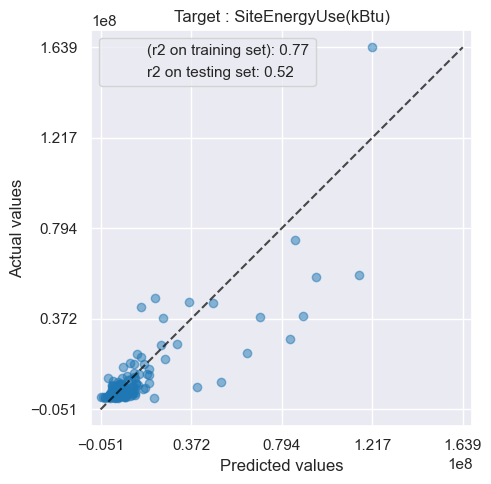

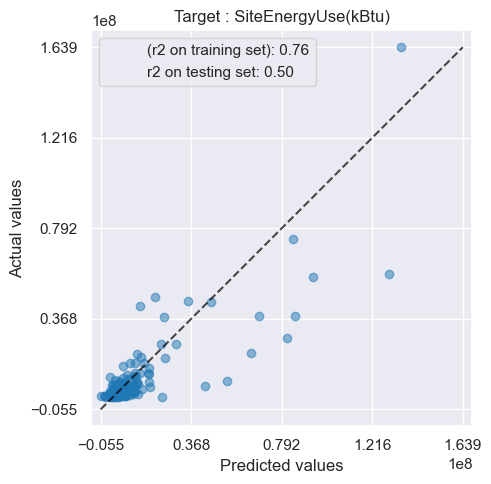

In [209]:
def pipe_bagging(alea, y, scaler, graph, model):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Create a BaggingRegressor with the model
    bagging_regressor = BaggingRegressor(estimator=model, n_estimators=20, random_state=42)

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("bag_regressor", bagging_regressor)
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_bagging_n_times(y=y_E, scaler=None, graph=True, model=None):
    print(f'Modèle : bagging {model}')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_bagging(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph,
                                                                                      model=model)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'bagg ' + str(model),
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_bagging_n_times(scaler=robust, graph=True, model=Ridge())
test_bagging_n_times(scaler=robust, graph=True, model=LinearRegression())


affichage_results()

# 


In [210]:
# un peu en avance, par curiosité
# RandomForestRegressor() possede un param bootstrap. 

rfr = RandomForestRegressor(n_estimators=500, oob_score=True)

# test_bagging_n_times(scaler=robust, graph=True, model=rfr)

affichage_results()


model    set  \
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
8                  Ridge (tuned)  data5   
10                 Ridge (tuned)  data6   

                                   scaler               target  r2_test_moy  \
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
28  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.118918   
8   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   
10  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.478570   


### 4.13 Random forest

Les arbres de décision sont des modèles non-paramétriques et trouvent des règles en général assez puissantes. Ils peuvent traiter des très grands datasets et ils peuvent aussi utiliser des prédicateurs mixtes (catégoriques et nombres). Les variables redondantes sont éliminées, parce que l’arbre ne les prend même pas en compte. 

Plus besoin de preprocess ??


les forêts aléatoires sont une amélioration du bagging puisqu'elles créent des arbres plus différents structurellement en échantillonnant aléatoirement seulement un sous-ensemble des features disponibles, ce qui permet de réduire la corrélation entre les arbres et donc d'obtenir un meilleur modèle final


In general, you don't need to scale numeric data when using a Random Forest Regressor. Random Forest models, including the Random Forest Regressor, are ensemble methods that are based on decision trees. Decision trees and Random Forests make splits in the data based on the values of individual features, without regard to the scale of the features. Scaling the features is not necessary for Random Forests because they are not sensitive to the scale of the input features.

However, there are certain situations where you might still want to scale your numeric data even when using Random Forest Regressor:

If you plan to visualize or interpret the feature importances: In this case, scaling can help make the feature importances more interpretable and consistent.

If you are combining Random Forest with other models in an ensemble or a pipeline: In some cases, you might want to scale features to ensure compatibility with other models that do require scaled features.

If you have other specific reasons related to the dataset or problem at hand: Sometimes, domain-specific knowledge or unique characteristics of your dataset might lead to a decision to scale features.

In most cases, Random Forests are robust to the scale of the input features, so you may not need to scale the numeric data. However, it's essential to experiment and determine what works best for your specific problem and dataset.

so, no scaling here i think ?


Modèle : random forest
target :  SiteEnergyUse(kBtu)
Iteration  1
R-squared (train) =  0.9110666904951974
R-squared (test) =  0.7225591662843305
RMSE (train) =  9684089.139593912
RMSE (test) =  9190073.186162405

{'model': 'random forest', 'set': 'data1', 'scaler': None, 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.7225591662843305, 'r2_test_std': 0.0, 'rmse_test_moy': 9190073.186162405, 'rmse_test_std': 0.0, 'r2_train_moy': 0.9110666904951974, 'r2_train_std': 0.0, 'rmse_train_moy': 9684089.139593912, 'rmse_train_std': 0.0, 'time_fit_moy': 9.385137845998543, 'time_fit_std': 0.0, 'time_predict_moy': 0.05677651199948741, 'time_predict_std': 0.0} 



model    set  \
32                 random forest  data1   
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
8                  Ridge (tuned)  data5   
10                 Ridge (tuned)  data6   

                                   scaler               target  r2_test_moy  \
32                                   None  SiteEnergyUse(kBtu)     0.722559   
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036237   
28  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)    -0.118918   
8   RobustScaler(quantile_range=(25,

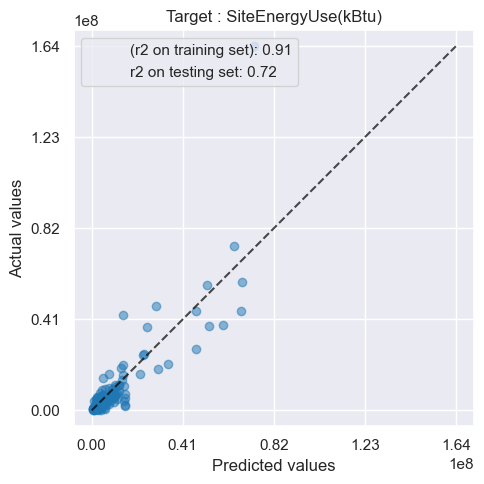

In [211]:
def pipe_forest(alea, y, scaler, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("forest_regressor", RandomForestRegressor(n_estimators=500, oob_score=True))
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_forest_n_times(y=y_E, scaler=None, graph=True):
    print(f'Modèle : random forest')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_forest(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'random forest',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_forest_n_times(scaler=None, graph=True)
# test_forest_n_times(scaler=robust, graph=True)


affichage_results()

# Elle fait mieux sans scaling.


Modèle : random forest
target :  SiteEnergyUse(kBtu)
Iteration  1
best_n_estimators: 100
best_max_depth: None
best_min_samples_split: 2
best_min_samples_leaf: 1
best_max_features: sqrt
R-squared (train) =  0.8864176594958517
R-squared (test) =  0.7131472166396036
RMSE (train) =  10944148.01547497
RMSE (test) =  9344655.894364089

{'model': 'random forest tuned', 'set': 'data1', 'scaler': None, 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.7131472166396036, 'r2_test_std': 0.0, 'rmse_test_moy': 9344655.894364089, 'rmse_test_std': 0.0, 'r2_train_moy': 0.8864176594958517, 'r2_train_std': 0.0, 'rmse_train_moy': 10944148.01547497, 'rmse_train_std': 0.0, 'time_fit_moy': 0.4863323149984353, 'time_fit_std': 0.0, 'time_predict_moy': 0.010515624002437107, 'time_predict_std': 0.0} 



model    set  \
32                 random forest  data1   
33           random forest tuned  data1   
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
9                  Ridge (tuned)  data5   
11                 Ridge (tuned)  data6   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
32                                   None  SiteEnergyUse(kBtu)     0.722559   
33                                   None  SiteEnergyUse(kBtu)     0.713147   
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.275924   
22  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.036

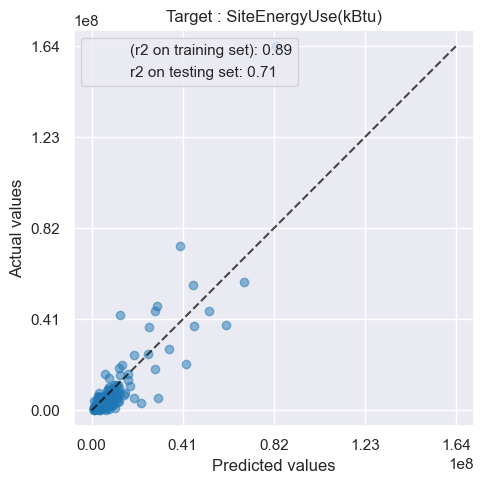

In [212]:
# gridsearch

def pipe_forest(alea, y, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=None)

    # Define the hyperparameter grid
    param_grid = {
        'forest_regressor__n_estimators': [100, 300],
        'forest_regressor__max_depth': [None, 10, 30],
        'forest_regressor__min_samples_split': [2, 5, 10],
        'forest_regressor__min_samples_leaf': [1, 2],
        'forest_regressor__max_features': ['sqrt']
    }

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("forest_regressor", RandomForestRegressor())
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters and best estimator
    best_n_estimators = grid_search.best_params_['forest_regressor__n_estimators']
    best_max_depth = grid_search.best_params_['forest_regressor__max_depth']
    best_min_samples_split = grid_search.best_params_['forest_regressor__min_samples_split']
    best_min_samples_leaf = grid_search.best_params_['forest_regressor__min_samples_leaf']
    best_max_features = grid_search.best_params_['forest_regressor__max_features']
    print(f"best_n_estimators: {best_n_estimators}")
    print(f"best_max_depth: {best_max_depth}")
    print(f"best_min_samples_split: {best_min_samples_split}")
    print(f"best_min_samples_leaf: {best_min_samples_leaf}")
    print(f"best_max_features: {best_max_features}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("forest_regressor", RandomForestRegressor(n_estimators=best_n_estimators,
                                                   max_depth=best_max_depth,
                                                   min_samples_split=best_min_samples_split,
                                                   min_samples_leaf=best_min_samples_leaf,
                                                   max_features=best_max_features))
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_forest_n_times(y=y_E,graph=True):
    print(f'Modèle : random forest')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_forest(alea=n,
                                                                                      y=y, 
                                                                                      graph=graph)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'random forest tuned',
               'set': dataset,
               'scaler': None,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_forest_n_times(graph=True)


affichage_results()


Modèle : random forest
target :  SiteEnergyUse(kBtu)
Iteration  1
R-squared (train) =  0.9016922808208662
R-squared (test) =  0.6784989561616857
RMSE (train) =  10181701.519811356
RMSE (test) =  9892930.844050916

{'model': 'random forest', 'set': 'data1', 'scaler': None, 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.6784989561616857, 'r2_test_std': 0.0, 'rmse_test_moy': 9892930.844050916, 'rmse_test_std': 0.0, 'r2_train_moy': 0.9016922808208662, 'r2_train_std': 0.0, 'rmse_train_moy': 10181701.519811356, 'rmse_train_std': 0.0, 'time_fit_moy': 4.831622579997202, 'time_fit_std': 0.0, 'time_predict_moy': 0.07447221000256832, 'time_predict_std': 0.0} 



model    set  \
32                 random forest  data1   
33           random forest tuned  data1   
34                 random forest  data1   
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
9                  Ridge (tuned)  data5   
11                 Ridge (tuned)  data6   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
32                                   None  SiteEnergyUse(kBtu)     0.722559   
33                                   None  SiteEnergyUse(kBtu)     0.713147   
34                                   None  SiteEnergyUse(kBtu)     0.678499   
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.304033   
21  RobustScaler(quantile_ran

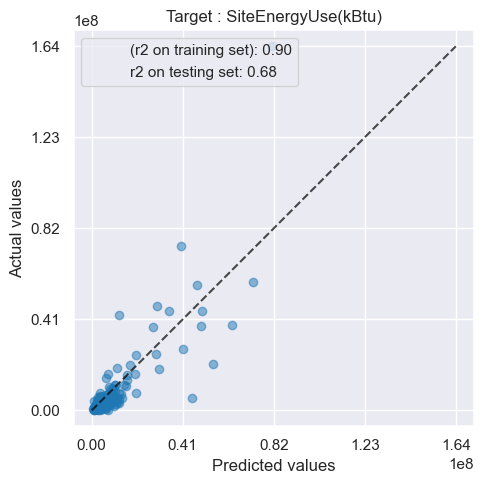

In [213]:
# tuned

def pipe_forest(alea, y, scaler, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("forest_regressor", RandomForestRegressor(n_estimators=1000,
                                                   max_depth=30,
                                                   min_samples_split=2,
                                                   min_samples_leaf=1,
                                                   max_features='sqrt'))
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_forest_n_times(y=y_E, scaler=None, graph=True):
    print(f'Modèle : random forest')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_forest(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'random forest',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_forest_n_times(scaler=None, graph=True)


affichage_results()


### 4.14 méthodes ensemblistes séquentielles

#### Gradient boosting : Adaboost regressor

Modèle : Adaboost
target :  SiteEnergyUse(kBtu)
Iteration  1
R-squared (train) =  0.6625879319024143
R-squared (test) =  -0.344800861968555
RMSE (train) =  18862830.280580215
RMSE (test) =  20233115.883478

{'model': 'Adaboost + trees, d=2', 'set': 'data1', 'scaler': None, 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': -0.344800861968555, 'r2_test_std': 0.0, 'rmse_test_moy': 20233115.883478, 'rmse_test_std': 0.0, 'r2_train_moy': 0.6625879319024143, 'r2_train_std': 0.0, 'rmse_train_moy': 18862830.280580215, 'rmse_train_std': 0.0, 'time_fit_moy': 0.053688793999754125, 'time_fit_std': 0.0, 'time_predict_moy': 0.006670826001936803, 'time_predict_std': 0.0} 

Modèle : Adaboost
target :  SiteEnergyUse(kBtu)
Iteration  1
R-squared (train) =  0.6634130518384072
R-squared (test) =  -0.3369081742549149
RMSE (train) =  18839752.231966708
RMSE (test) =  20173654.04349538

{'model': 'Adaboost + trees, d=2', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(k

model    set  \
32                 random forest  data1   
33           random forest tuned  data1   
34                 random forest  data1   
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
36         Adaboost + trees, d=2  data1   
35         Adaboost + trees, d=2  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
32                                   None  SiteEnergyUse(kBtu)     0.722559   
33                                   None  SiteEnergyUse(kBtu)     0.713147   
34                                   None  SiteEnergyUse(kBtu)     0.678499   
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quant

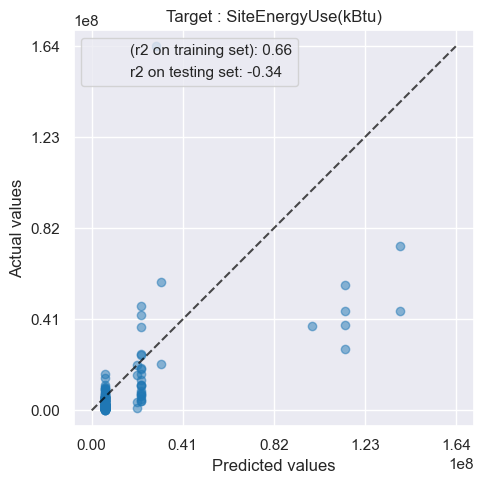

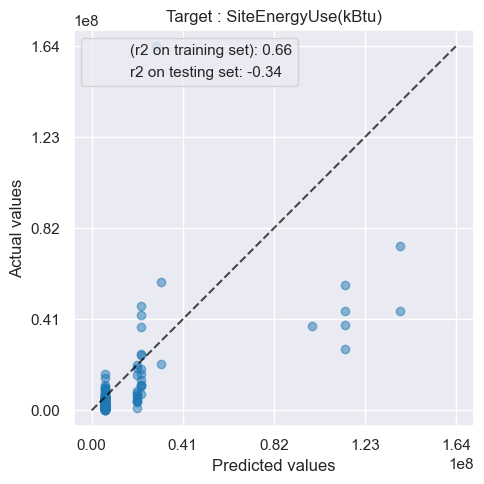

In [214]:
def pipe_ada(alea, y, scaler, graph, depth):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)
    
    # Create an AdaBoostRegressor with a DecisionTreeRegressor as the base estimator
    estimator = DecisionTreeRegressor(max_depth=depth) # try =1 for stumps, compare
    adaboost_regressor = AdaBoostRegressor(estimator=estimator, n_estimators=50, random_state=42)


    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ada_regressor", adaboost_regressor)
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_ada_n_times(y=y_E, scaler=None, graph=True, depth=2):
    print('Modèle : Adaboost')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_ada(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph,
                                                                                      depth=depth)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Adaboost + trees, d=' + str(depth),
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_ada_n_times(scaler=None, graph=True, depth=2)
test_ada_n_times(scaler=robust, graph=True, depth=2)


affichage_results()

# 


#### GradientBoostingRegressor

Les hyperparamètres à optimiser quand on travaille avec le gradient boosting sont learning_rate qui permet le shrinkage pour la régularisation et le nombre de classifieurs n_estimators qui détermine le nombre d'arbres à utiliser.

In [215]:
# gridsearch

def pipe_gradient(alea, y, graph, scaler):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Define the hyperparameter grid
    param_grid = {
        'gradient_regressor__n_estimators': [100, 300],
        'gradient_regressor__learning_rate': [0.1, 0.2],
        'gradient_regressor__max_depth': [5, 7, 10],
        'gradient_regressor__min_samples_split': [2, 5],
        'gradient_regressor__min_samples_leaf': [1, 2],
        'gradient_regressor__max_features': ['sqrt'],
        'gradient_regressor__subsample': [0.9, 1.0]
    }

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("gradient_regressor", GradientBoostingRegressor())
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_n_estimators = grid_search.best_params_['gradient_regressor__n_estimators']
    best_learning_rate = grid_search.best_params_['gradient_regressor__learning_rate']
    best_max_depth = grid_search.best_params_['gradient_regressor__max_depth']
    best_min_samples_split = grid_search.best_params_['gradient_regressor__min_samples_split']
    best_min_samples_leaf = grid_search.best_params_['gradient_regressor__min_samples_leaf']
    best_max_features = grid_search.best_params_['gradient_regressor__max_features']
    best_subsample = grid_search.best_params_['gradient_regressor__subsample']

    print(f"Best n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best min_samples_split: {best_min_samples_split}")
    print(f"Best min_samples_leaf: {best_min_samples_leaf}")
    print(f"Best max_features: {best_max_features}")
    print(f"Best subsample: {best_subsample}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("gradient_regressor", GradientBoostingRegressor(
            n_estimators=best_n_estimators,
            learning_rate=best_learning_rate,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            max_features=best_max_features,
            subsample=best_subsample))
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_gradient_n_times(y=y_E, graph=True, scaler=robust):
    print(f'Modèle : gradient boosting')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_gradient(alea=n,
                                                                                      y=y, 
                                                                                      graph=graph,
                                                                                      scaler=scaler)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'gradient boosting',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# test_gradient_n_times(graph=True, scaler=robust)


affichage_results()

# no


model    set  \
32                 random forest  data1   
33           random forest tuned  data1   
34                 random forest  data1   
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
11                 Ridge (tuned)  data6   
9                  Ridge (tuned)  data5   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
36         Adaboost + trees, d=2  data1   
35         Adaboost + trees, d=2  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
32                                   None  SiteEnergyUse(kBtu)     0.722559   
33                                   None  SiteEnergyUse(kBtu)     0.713147   
34                                   None  SiteEnergyUse(kBtu)     0.678499   
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.311591   
1   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.307232   
13  RobustScaler(quant

### 4.16 XGBoost

In [216]:
# gridsearch
# Très long. Simplifier param_grid,
# use random search ?

def pipe_xgb(alea, y, graph, scaler):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Define the hyperparameter grid
    param_grid = {
        'xgb_regressor__n_estimators': [100, 200, 300],
        'xgb_regressor__learning_rate': [0.01, 0.1, 0.2],
        'xgb_regressor__max_depth': [3, 4, 5, 6],
        'xgb_regressor__min_child_weight': [1, 2, 4],
        'xgb_regressor__subsample': [0.8, 0.9, 1.0],
        'xgb_regressor__colsample_bytree': [0.8, 0.9, 1.0],
        'xgb_regressor__gamma': [0, 0.1, 0.2],
        'xgb_regressor__reg_alpha': [0, 0.1, 1],
        'xgb_regressor__reg_lambda': [0, 0.1, 1]
    }

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("xgb_regressor", XGBRegressor())
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_n_estimators = grid_search.best_params_['gradient_regressor__n_estimators']
    best_learning_rate = grid_search.best_params_['gradient_regressor__learning_rate']
    best_max_depth = grid_search.best_params_['gradient_regressor__max_depth']
    best_min_samples_split = grid_search.best_params_['gradient_regressor__min_samples_split']
    best_min_samples_leaf = grid_search.best_params_['gradient_regressor__min_samples_leaf']
    best_max_features = grid_search.best_params_['gradient_regressor__max_features']
    best_subsample = grid_search.best_params_['gradient_regressor__subsample']

    print(f"Best n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best min_samples_split: {best_min_samples_split}")
    print(f"Best min_samples_leaf: {best_min_samples_leaf}")
    print(f"Best max_features: {best_max_features}")
    print(f"Best subsample: {best_subsample}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("gradient_regressor", GradientBoostingRegressor(
            n_estimators=best_n_estimators,
            learning_rate=best_learning_rate,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            max_features=best_max_features,
            subsample=best_subsample))
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_xgb_n_times(y=y_E, graph=True, scaler=robust):
    print(f'Modèle : xgboost')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_xgb(alea=n,
                                                                                      y=y, 
                                                                                      graph=graph,
                                                                                      scaler=scaler)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'xgboost',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# test_xgb_n_times(graph=True, scaler=robust)


# affichage_results()


Modèle : xgboost
target :  SiteEnergyUse(kBtu)
Iteration  1
R-squared (train) =  0.9741127744953617
R-squared (test) =  0.6719676598367628
RMSE (train) =  5224795.59641927
RMSE (test) =  9992913.097373795

{'model': 'xgboost dft', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.6719676598367628, 'r2_test_std': 0.0, 'rmse_test_moy': 9992913.097373795, 'rmse_test_std': 0.0, 'r2_train_moy': 0.9741127744953617, 'r2_train_std': 0.0, 'rmse_train_moy': 5224795.59641927, 'rmse_train_std': 0.0, 'time_fit_moy': 0.2990098170012061, 'time_fit_std': 0.0, 'time_predict_moy': 0.004576702998747351, 'time_predict_std': 0.0} 



model    set  \
32                 random forest  data1   
33           random forest tuned  data1   
34                 random forest  data1   
37                   xgboost dft  data1   
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
9                  Ridge (tuned)  data5   
11                 Ridge (tuned)  data6   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
36         Adaboost + trees, d=2  data1   
35         Adaboost + trees, d=2  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
32                                   None  SiteEnergyUse(kBtu)     0.722559   
33                                   None  SiteEnergyUse(kBtu)     0.713147   
34                                   None  SiteEnergyUse(kBtu)     0.678499   
37  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.671968   
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu

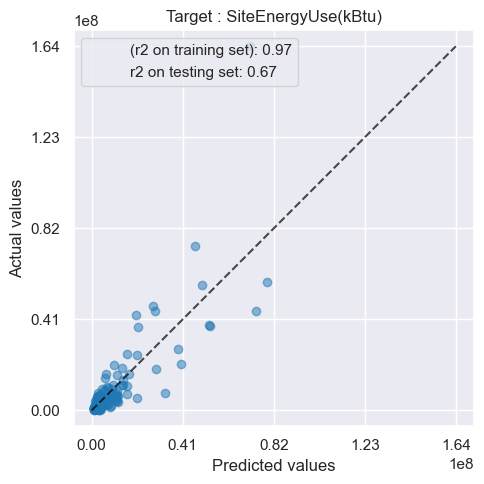

In [217]:
# default parameters

def pipe_xgb(alea, y, graph, scaler):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Create a pipeline 
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("gradient_regressor", GradientBoostingRegressor())
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_xgb_n_times(y=y_E, graph=True, scaler=robust):
    print(f'Modèle : xgboost')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_xgb(alea=n,
                                                                                      y=y, 
                                                                                      graph=graph,
                                                                                      scaler=scaler)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'xgboost dft',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_xgb_n_times(graph=True, scaler=robust)


affichage_results()


### Comparaison, Modèle choisi

In [218]:
# En observants les résultats obtenus (en particulier r2_test moyen),
# nous pouvons évaluer les performances de nos nos modèles.

# La différence entre r2_test et r2_val ou r2_train nous renseigne sur la capacité du modèle
# à généraliser ou, au contraire, sa tendance à avoir un biais excessif, à overfitter.

# La variation standard de ces indicateurs nous renseigne sur sa stabilité.


# tps?


## 5 Interprétation, importance de la feature 'ENERGYSTARSscore'

In [219]:
df = pd.read_csv('star_score_subset.csv', sep=',')

print(df.shape)
display(df.head())

cat, num, X, y_E, y_EI, dataset = unpack_data(df, 'data8')


(997, 16)


BuildingType PrimaryPropertyType Neighborhood  YearBuilt  \
0  NonResidential               Hotel     DOWNTOWN       1927   
1  NonResidential               Hotel     DOWNTOWN       1996   
2  NonResidential               Hotel     DOWNTOWN       1969   
3  NonResidential               Hotel     DOWNTOWN       1926   
4  NonResidential               Hotel     DOWNTOWN       1980   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  proportion_parking  \
0                1.0              12             88434            0.000000   
1                1.0              11            103566            0.145453   
2                1.0              41            956110            0.205748   
3                1.0              10             61320            0.000000   
4                1.0              18            175580            0.353115   

   proportion_electricity  proportion_gaz  proportion_steam  \
0                0.546060        0.176638          0.277302   
1                0.386609        0.613391          0.000000   
2                0.682307        0.020579          0.297113   
3                0.407519        0.266567          0.325913   
4                0.378802        0.621198          0.000000   

   SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0            7226362.5         81.699997             249.98   
1            8387933.0         94.800003             295.86   
2           72587024.0         96.000000            2089.28   
3            6794584.0        110.800003             286.43   
4           14172606.0        114.800003             505.01   

   GHGEmissionsIntensity  star_score  
0                   2.83        60.0  
1                   2.86        61.0  
2                   2.19        43.0  
3                   4.67        56.0  
4                   2.88        75.0

### 5.1 Lecture des coefficients d'un modèle linéaire (dataframe)

In [220]:
# In the following section, we will interpret the coefficients of the model. While we do so, 
# we should keep in mind that any conclusion we draw is about the model that we build, 
# rather than about the true (real-world) generative process of the data. (scikit)

# using our good old Ridge as an example 

def pipe_ridge_coeffs(y, graph=False):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=42, test_size=test_size, \
                                                                    scaler=robust)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge_regressor", Ridge())
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'ridge_regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters 
    best_alpha = grid_search.best_params_['ridge_regressor__alpha']
    print(f"Best alpha: {best_alpha}")

    # Create a pipeline with the preprocessor and the tuned Ridge regressor
    pipeline_with_tuned_ridge = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ridge_regressor", Ridge(alpha=best_alpha))  # Use the tuned alpha value here
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_ridge, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_ridge, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_ridge, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_ridge.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    feature_names = pipe[:-1].get_feature_names_out()
    # print(feature_names)

    coefs = pd.DataFrame(
        pipeline_with_tuned_ridge.named_steps['ridge_regressor'].coef_,
        columns=["Coefficients"],
        index=feature_names,
    )

    display(coefs)


pipe_ridge_coeffs(y_E)


Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.47222733354927526
Split 2 : r2 = 0.815522945187961
Split 3 : r2 = 0.13995392641350668
Split 4 : r2 = 0.27550776520861586
Split 5 : r2 = 0.8689543323924261
R-squared (val) =  0.514433260550357
R-squared (train) =  0.6009804958879696
R-squared (test) =  -0.6889755215144593
RMSE (val) =  19540525.639612824
RMSE (train) =  17029609.077253453
RMSE (test) =  14133192.932847997



Coefficients
categorical__BuildingType_Campus                    2.502482e+07
categorical__BuildingType_NonResidential           -1.335135e+07
categorical__BuildingType_Nonresidential COS       -7.435503e+06
categorical__BuildingType_SPS-District K-12        -4.237965e+06
categorical__PrimaryPropertyType_Distribution C... -6.557685e+06
categorical__PrimaryPropertyType_Hospital           1.975470e+07
categorical__PrimaryPropertyType_Hotel             -2.090608e+06
categorical__PrimaryPropertyType_K-12 School       -8.525370e+06
categorical__PrimaryPropertyType_Large Office      -5.888926e+06
categorical__PrimaryPropertyType_Low-Rise Multi... -6.837213e+05
categorical__PrimaryPropertyType_Medical Office    -2.624545e+06
categorical__PrimaryPropertyType_Mixed Use Prop...  1.138803e+07
categorical__PrimaryPropertyType_Other              1.592601e+07
categorical__PrimaryPropertyType_Refrigerated W... -1.155164e+06
categorical__PrimaryPropertyType_Residence Hall    -3.106381e+06
categorical__PrimaryPropertyType_Retail Store      -2.388514e+06
categorical__PrimaryPropertyType_Senior Care Co... -7.359720e+05
categorical__PrimaryPropertyType_Small- and Mid... -2.299371e+06
categorical__PrimaryPropertyType_Supermarket / ...  1.012705e+06
categorical__PrimaryPropertyType_Warehouse         -7.362207e+06
categorical__PrimaryPropertyType_Worship Facility  -4.662977e+06
categorical__Neighborhood_BALLARD                  -1.117777e+06
categorical__Neighborhood_Ballard                  -2.148082e+05
categorical__Neighborhood_CENTRAL                  -4.205023e+06
categorical__Neighborhood_Central                  -3.929273e+05
categorical__Neighborhood_DELRIDGE                  3.741069e+05
categorical__Neighborhood_DOWNTOWN                  4.778568e+04
categorical__Neighborhood_Delridge                  1.273679e+06
categorical__Neighborhood_EAST                      3.089717e+06
categorical__Neighborhood_GREATER DUWAMISH          1.326030e+06
categorical__Neighborhood_LAKE UNION               -1.252047e+05
categorical__Neighborhood_MAGNOLIA / QUEEN ANNE    -1.814994e+05
categorical__Neighborhood_NORTH                    -9.602184e+05
categorical__Neighborhood_NORTHEAST                 3.406999e+05
categorical__Neighborhood_NORTHWEST                 2.080338e+05
categorical__Neighborhood_North                    -4.334520e+04
categorical__Neighborhood_Northwest                 1.034686e+05
categorical__Neighborhood_SOUTHEAST                -6.366443e+05
categorical__Neighborhood_SOUTHWEST                 1.113927e+06
numerical__YearBuilt                                1.875714e+05
numerical__NumberofBuildings                        1.587293e+07
numerical__NumberofFloors                          -7.303543e+05
numerical__PropertyGFATotal                         6.789005e+06
numerical__proportion_parking                      -5.811008e+06
numerical__proportion_electricity                  -4.507693e+06
numerical__proportion_gaz                          -1.988602e+06
numerical__proportion_steam                         4.633263e+06
numerical__star_score                              -4.631891e+06

In [221]:
# On peut maintenant facilement mesurer de combien l'augmentation ou la diminution d'une feature (de +1 ou -1)
# va impacter la valeur prédite par le modèle.

# D'après ce modèle, donc, on peut par exemple constater que :

# Plus on a de surface, plus on consomme ! (Trivial mais vrai)
# Les immeubles plus récents consomment davantage. (Moins intuitif)


### 5.2 Lecture des coefficients pondérés (visualisation)

Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.47222733354927526
Split 2 : r2 = 0.815522945187961
Split 3 : r2 = 0.13995392641350668
Split 4 : r2 = 0.27550776520861586
Split 5 : r2 = 0.8689543323924261
R-squared (val) =  0.514433260550357
R-squared (train) =  0.6009804958879696
R-squared (test) =  -0.6889755215144593
RMSE (val) =  19540525.639612824
RMSE (train) =  17029609.077253453
RMSE (test) =  14133192.932847997



model    set  \
32                 random forest  data1   
33           random forest tuned  data1   
34                 random forest  data1   
37                   xgboost dft  data1   
6                  Ridge (tuned)  data4   
25                         Lasso  data1   
30                  bagg Ridge()  data1   
23  Ridge, ba=2.2051307399030455  data1   
4                  Ridge (tuned)  data3   
29                       rbf krr  data1   
2                  Ridge (tuned)  data2   
27                    Linear SVR  data1   
0                  Ridge (tuned)  data1   
31       bagg LinearRegression()  data1   
14                           kNN  data1   
26                   Elastic_net  data1   
12                 Ridge (tuned)  data7   
19            Ridge, alpha = 0.1  data1   
18           Ridge, alpha = 0.01  data1   
17          Ridge, alpha = 0.001  data1   
16              Ridge, alpha = 0  data1   
15                        Linear  data1   
7                  Ridge (tuned)  data4   
24  Ridge, ba=3.5111917342151346  data1   
3                  Ridge (tuned)  data2   
20            Ridge, alpha = 100  data1   
9                  Ridge (tuned)  data5   
11                 Ridge (tuned)  data6   
5                  Ridge (tuned)  data3   
1                  Ridge (tuned)  data1   
13                 Ridge (tuned)  data7   
21           Ridge, alpha = 1000  data1   
22        Ridge, alpha = 1000000  data1   
28                rbf kernel SVR  data1   
36         Adaboost + trees, d=2  data1   
35         Adaboost + trees, d=2  data1   
10                 Ridge (tuned)  data6   
8                  Ridge (tuned)  data5   

                                   scaler               target  r2_test_moy  \
32                                   None  SiteEnergyUse(kBtu)     0.722559   
33                                   None  SiteEnergyUse(kBtu)     0.713147   
34                                   None  SiteEnergyUse(kBtu)     0.678499   
37  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.671968   
6   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.581915   
25  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.549113   
30  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.515637   
23  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.504370   
4   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.503646   
29  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500941   
2   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.500645   
27  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499546   
0   RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.499173   
31  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.495232   
14  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.491231   
26  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.489348   
12  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.488408   
19  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.484251   
18  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.482013   
17  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481779   
16  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.481753   
15  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.480453   
7   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.346450   
24  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.341375   
3   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.339611   
20  RobustScaler(quantile_range=(25, 75))  SiteEnergyUse(kBtu)     0.328507   
9   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
11  RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu/sf)     0.321410   
5   RobustScaler(quantile_range=(25, 75))     SiteEUI(kBtu

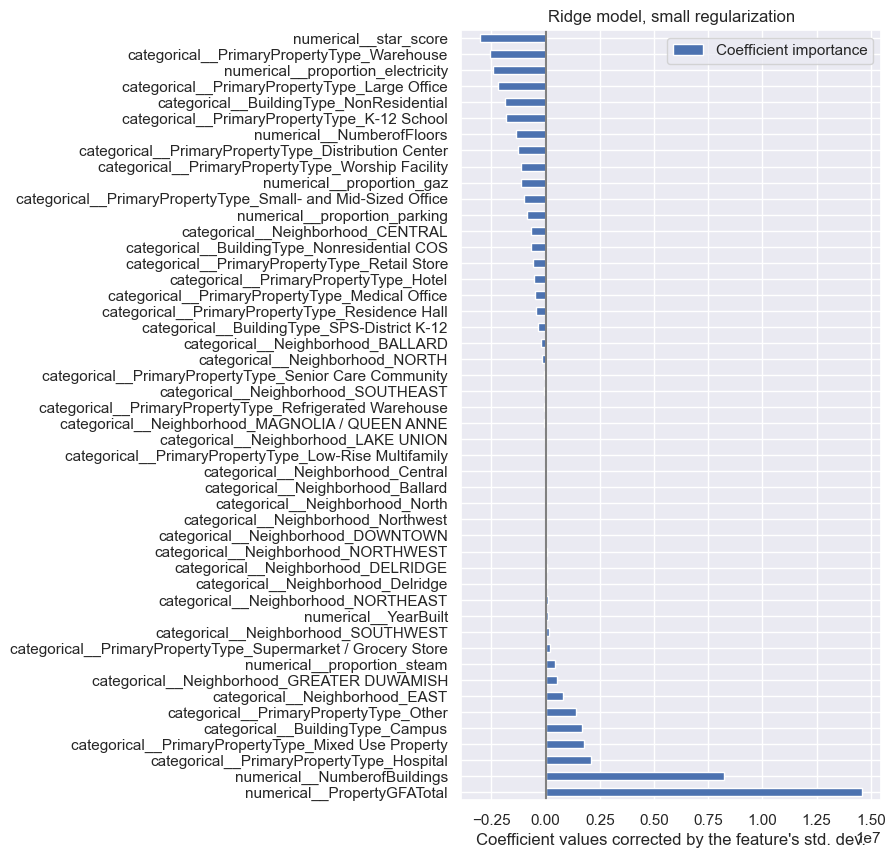

In [222]:
# avec coeffs pondérés par la variance des features 
# -> permet de comparer l'importance relative des features selon ce modèle.

def pipe_ridge_coeffs(y, graph=False):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=42, test_size=test_size, \
                                                                    scaler=robust)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge_regressor", Ridge())
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'ridge_regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters 
    best_alpha = grid_search.best_params_['ridge_regressor__alpha']
    print(f"Best alpha: {best_alpha}")

    # Create a pipeline with the preprocessor and the tuned Ridge regressor
    pipeline_with_tuned_ridge = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ridge_regressor", Ridge(alpha=best_alpha))  # Use the tuned alpha value here
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_ridge, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_ridge, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_ridge, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_ridge.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Preprocess the training data
    X_train_preprocessed = pipeline_with_tuned_ridge.named_steps['preprocessor'].transform(X_train)
    feature_names = pipeline_with_tuned_ridge.named_steps['preprocessor'].get_feature_names_out()

    # If X_train_preprocessed is a sparse matrix, convert it to a dense matrix for std calculation
    X_train_preprocessed = X_train_preprocessed.toarray()

    #  Calculate the coefficients
    coefs = pd.DataFrame(
        pipeline_with_tuned_ridge.named_steps['ridge_regressor'].coef_ * np.std(X_train_preprocessed, axis=0),
        columns=["Coefficient importance"],
        index=feature_names,
    )
    
    # Sort the DataFrame 
    coefs.sort_values(by='Coefficient importance', ascending=False, inplace=True)

    coefs.plot(kind="barh", figsize=(7, 10))
    plt.xlabel("Coefficient values corrected by the feature's std. dev.")
    plt.title("Ridge model, small regularization")
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)


pipe_ridge_coeffs(y_E)

affichage_results()


In [223]:
# A garder en tête :

# Coefficients must be scaled to the same unit of measure to retrieve feature importance. 
# Scaling them with the standard-deviation of the feature is a useful proxy.
# Coefficients in multivariate linear models represent the dependency between a given feature and the target, 
# conditional on the other features.

# Correlated features induce instabilities in the coefficients of linear models and their effects cannot be 
# well teased apart. Different linear models respond differently to feature correlation and coefficients could
# significantly vary from one another.

# Inspecting coefficients across the folds of a cross-validation loop gives an idea of their stability.
# Coefficients are unlikely to have any causal meaning. They tend to be biased by unobserved confounders.
# Inspection tools may not necessarily provide insights on the true data generating process.


In [224]:
# Nous pouvons maintenant faire des comparaisons, par exemple :

# Les bureaux consomment moins que les hôpitaux.
# Construisons des bureaux !

# Nous pourrions aussi utiliser ce type de visualisation pour filtrer les features 
# que le modèle considère comme moins utiles.

# Cependant cette approche est limitée aux modèles linéaires,
# et plutôt à l'analyse globale. 
# Pour interpréter un modèle plus complexe comme nos gagnants (xgboost, random forest),
# nous allons avoir besoin d'outils spécifiques.


### 5.3 SelectFromModel(), feature_importances_

Modèle : random forest
target :  SiteEnergyUse(kBtu)
Iteration  1


R-squared (train) =  0.9270817940632787
R-squared (test) =  0.7124182351260504
RMSE (train) =  6944375.497680613
RMSE (test) =  14278967.545463463

nb features after selection :  17 

0.04666903959787409


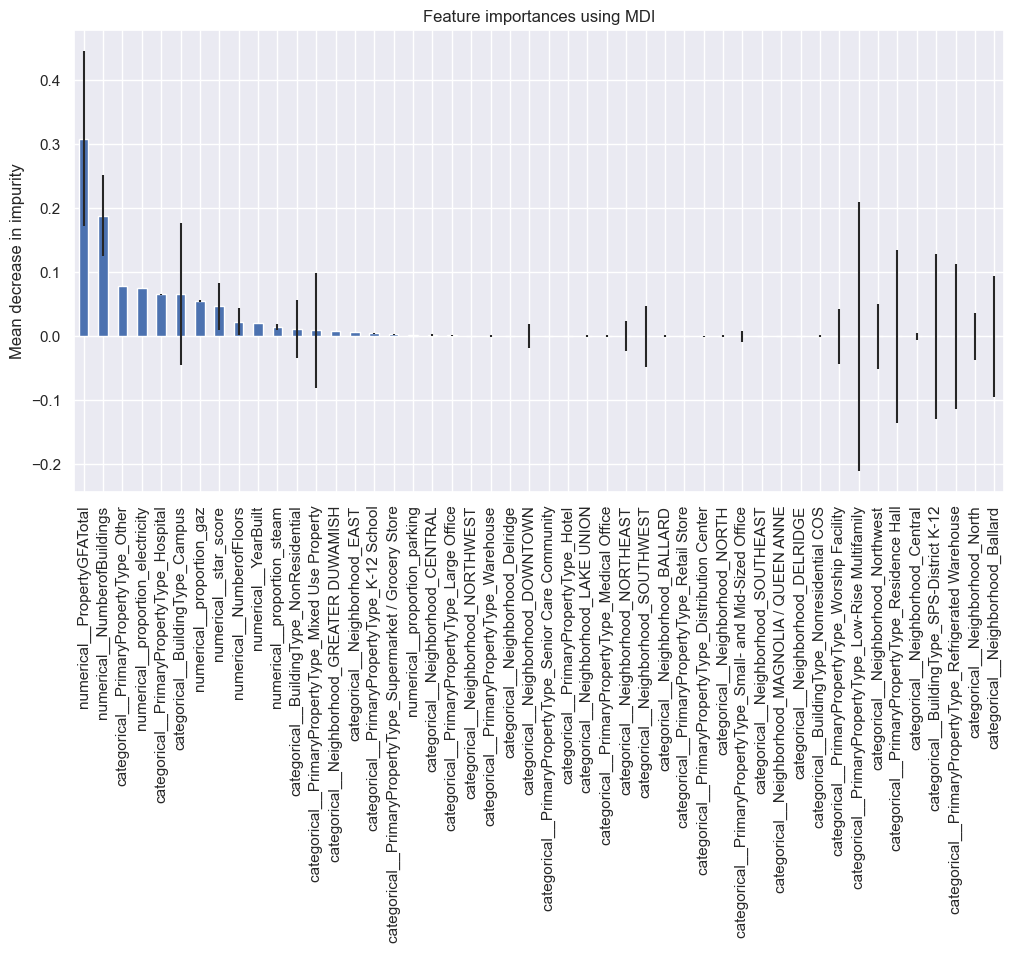

{'model': 'random forest', 'set': 'data8', 'scaler': None, 'target': 'SiteEnergyUse(kBtu)', 'r2_test_moy': 0.7124182351260504, 'r2_test_std': 0.0, 'rmse_test_moy': 14278967.545463463, 'rmse_test_std': 0.0, 'r2_train_moy': 0.9270817940632787, 'r2_train_std': 0.0, 'rmse_train_moy': 6944375.497680613, 'rmse_train_std': 0.0, 'time_fit_moy': 4.951704769999196, 'time_fit_std': 0.0, 'time_predict_moy': 0.03382043600140605, 'time_predict_std': 0.0} 



In [225]:
def pipe_forest(alea, y, scaler, graph, input_features):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Our model
    rfr = RandomForestRegressor(n_estimators=500, oob_score=True)

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("forest_regressor", rfr)
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    select = SelectFromModel(rfr, prefit=True, threshold=0.003)

    # Fit and transform the preprocessor on the training data to get post-preprocessing feature names
    X_train_transformed = preprocessor.fit_transform(X_train)

    X_train2 = select.transform(X_train_transformed)
    print('nb features after selection : ', X_train2.shape[1], '\n')

    feature_names = preprocessor.get_feature_names_out(input_features=input_features)
    # print(feature_names)

    importances = rfr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)
    print(forest_importances['numerical__star_score'])

    # Sort the feature importances by mean decrease in impurity
    sorted_importances = forest_importances.sort_values(ascending=False)

    plt.figure(figsize=(12, 6))  

    sorted_importances.plot.bar(yerr=std)
    plt.title("Feature importances using MDI")
    plt.ylabel("Mean decrease in impurity")

    plt.show()


    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_forest_n_times(y=y_E, scaler=None, graph=True, input_features=cat + num):
    print(f'Modèle : random forest')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_forest(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph,
                                                                                      input_features=input_features)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'random forest',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')


test_forest_n_times(scaler=None, graph=False, input_features=cat + num)


### 5.4 SHAP

R-squared (train) =  0.9899869112530836
R-squared (test) =  0.6584137632126991
RMSE (train) =  2697687.5587082547
RMSE (test) =  6355925.40816982

Interprétation globale


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


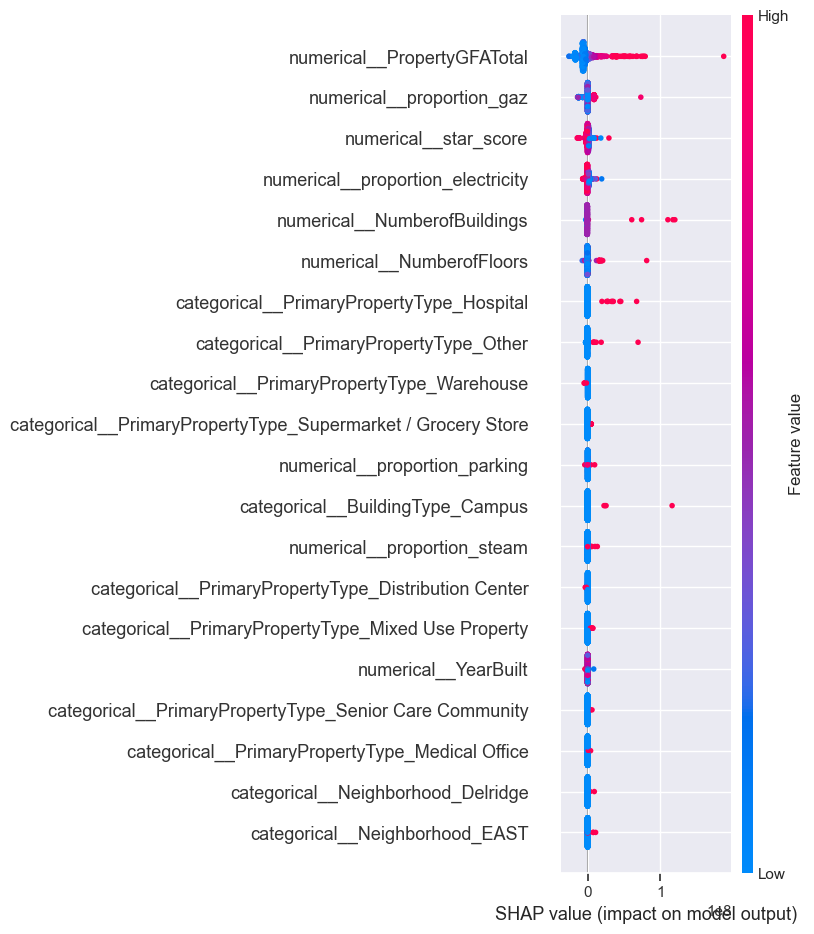

Interprétation locale


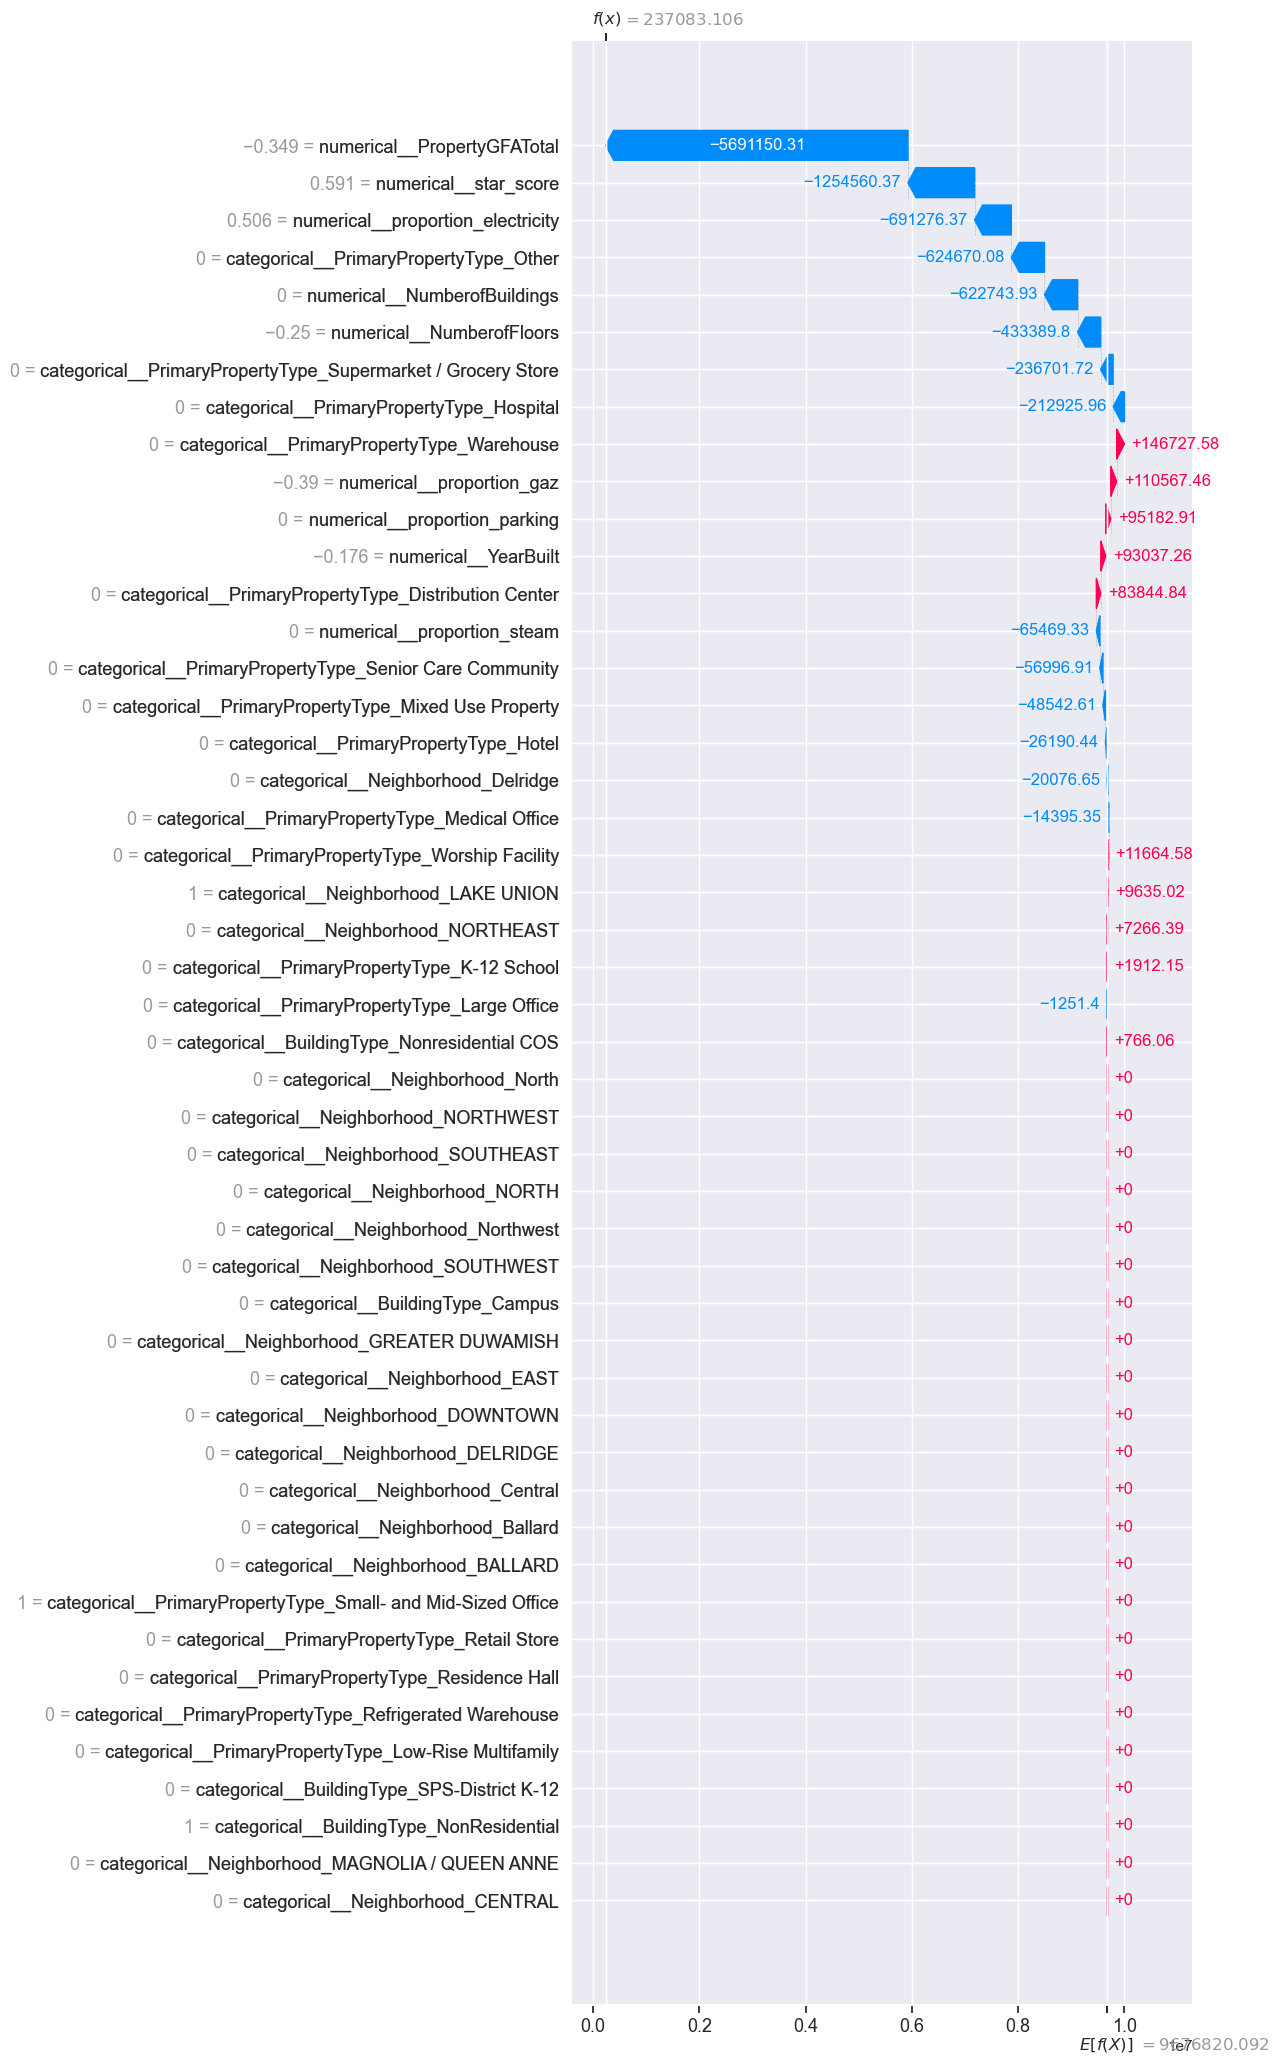

In [226]:
# Interprétation xgboost

def pipe_xgb(alea, y, graph, scaler,):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Create a pipeline 
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("gradient_regressor", GradientBoostingRegressor())
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # SHAP

    # Preprocess the data
    X_train_preprocessed = pipe_tuned.named_steps['preprocessor'].transform(X_train)
    X_test_preprocessed = pipe_tuned.named_steps['preprocessor'].transform(X_test)

    # Get the feature names from the preprocessor (change 'preprocessor' to the actual preprocessor name if different)
    feature_names = pipe_tuned.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)

    # If X_train_preprocessed is a sparse matrix, convert it to a dense matrix for std calculation
    X_train_preprocessed = X_train_preprocessed.toarray()
    X_test_preprocessed = X_test_preprocessed.toarray()

    # Calculate shap values
    model = pipe_tuned.named_steps["gradient_regressor"]
    explainer = shap.Explainer(model, X_train_preprocessed, feature_names=feature_names)
    shap_values = explainer(X_train_preprocessed)

    # You can visualize the summary plot to interpret the global model
    print('Interprétation globale')
    shap.summary_plot(shap_values, X_train_preprocessed, feature_names=feature_names)

    # Local : for a particular sample of data.
    print('Interprétation locale')
    shap.waterfall_plot(shap_values[0], max_display=len(feature_names))
    

pipe_xgb(42, y_E, graph=True, scaler=robust)


In [227]:
# On retrouve des similarités avec les coeffs pondérés des modèles linéaires
